<a href="https://colab.research.google.com/github/Laeti-dev/Project3---Automated-Data-Completion-for-Open-Food-Facts-Database/blob/master/Ikusawa_Laetitia_1_notebook_042024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
!pip install plotly
!pip install scikit-learn
# !pip install missingno

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import re
import unicodedata
from scipy import stats as sts
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

In [ ]:
# set seaborn chart background as default
sns.set()

# Import data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
original = pd.read_csv("/content/drive/MyDrive/OC/Projets/P3/data/fr.openfoodfacts.org.products.csv", sep='\t')

<ipython-input-5-e5cb8a85add3>:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  original = pd.read_csv("/content/drive/MyDrive/OC/Projets/P3/data/fr.openfoodfacts.org.products.csv", sep='\t')


In [ ]:
original_shape = original.shape
original_shape

(320772, 162)

# Functions - Automatisation

## Select variables

After a prior analysis of the dataset, we were able to define a function to filter the dataframe on conditions and select the interesting variables

In [ ]:
def select_variables(
    dataframe,
    columns_to_keep=None,
    min_cat_values=0.5,
    country = 'france',
    not_used_columns=None,
    var_maybe_not_useful=None,
    target="nutrition_grade_fr",
    ):
  """
  Main dataframe cleaning function
  Parameters :
  ------------
    - dataframe:  original dataframe
    - columns_to_keep: List: A list of columns to keep
    - min_cat_values: float: Minimum percentage of missing values for categorical variables
    - country: str: Country to filter the dataframe
    - not_used_columns: List: A list of columns to drop
    - var_maybe_not_useful: List: A list of columns to drop
    - target: str: Target column name
  Returns :
  ----------
    - dataframe: cleaned dataframe
  """
  if columns_to_keep is None:
        columns_to_keep = []
  if not_used_columns is None:
      not_used_columns = []
  if var_maybe_not_useful is None:
      var_maybe_not_useful = []

  small_df = dataframe.copy()
  # Drop variables non pertinentes
  small_df.drop(columns=not_used_columns, inplace=True)
  if len(var_maybe_not_useful) > 0:
      small_df.drop(columns=var_maybe_not_useful, inplace=True)

  # categorical variables
  cat = small_df.select_dtypes(include='object')
  # drop columns variable with less than x% missing values
  cat.drop(columns=cat.columns[cat.isnull().mean()>min_cat_values], inplace=True)

  if len(columns_to_keep) == 0:
      for var in cat.columns:
        if var not in columns_to_keep:
          columns_to_keep.append(var)

  for pnns in ["pnns_groups_1", 'pnns_groups_2']:
    if pnns not in columns_to_keep:
      columns_to_keep.append(pnns)

  # numerical variables
  num = small_df.select_dtypes(include='float64')
  # drop numerical variables without values
  col_nutri = num.columns[num.isnull().mean() < 1]
  for col in col_nutri: # On ne garde pas les nutrition_score
    if col  != "nutrition-score-uk_100g":
      columns_to_keep.append(col)

  return columns_to_keep

def filter_df(dataframe, columns_to_keep, country = 'france',target="nutrition_grade_fr"):
  """
  Filter dataframe by country and target
  Parameters :
  ------------
    - dataframe: original dataframe
    - country: str: Country to filter the dataframe
    - target: str: Target column name
  Returns :
  ----------
    - dataframe: filtered dataframe
  """
  french_df = dataframe[columns_to_keep].copy()
  # select products available in France
  french_df.dropna(subset=['countries_tags'],inplace=True)
  french = french_df[french_df['countries_tags'].str.contains(country)]
  countries = french.filter(regex=r'countries')
  french.drop(columns=countries, inplace=True)

  # get rid of few columns
  states = french.filter(regex='states').columns
  french.drop(columns=states, inplace=True)
  tags = french.filter(regex='tag').columns

  # pnns categories correction
  french["pnns_groups_1"] = french["pnns_groups_1"].replace(["cereals-and-potatoes", "sugary-snacks", "fruits-and-vegetables"], ["Cereals and potatoes", "Sugary snacks", "Fruits and vegetables"])

  # change biotin_100g for vitamin-b8_100g and pantothenic-acid_100g for vitamin-b5_100g
  new_names = {'biotin_100g': 'vitamin-b8_100g', 'pantothenic-acid_100g': 'vitamin-b5_100g'}
  french = french.rename(columns=new_names)
  # move values from folates_100g to vitamin-9_100g then drop folates_100g column
  french.loc[french["folates_100g"].notnull(), "vitamin-b9_100g"] = french["folates_100g"]
  french.drop(columns="folates_100g", inplace=True)

  # Suprimer lignes avec target nulle
  french.dropna(subset="nutrition_grade_fr", inplace=True)

  return french


def select_columns_between_excluding_end(df, start_col, end_col):
    """
    Sélectionne toutes les colonnes d'un DataFrame entre deux colonnes spécifiques, excluant la colonne de fin.

    Args:
    df (pd.DataFrame): Le DataFrame d'origine.
    start_col (str): Le nom de la colonne de début.
    end_col (str): Le nom de la colonne de fin à exclure.

    Returns:
    pd.DataFrame: Un DataFrame contenant les colonnes sélectionnées, excluant la colonne de fin.
    """
    # Vérifier que les colonnes spécifiées existent dans le DataFrame
    if start_col not in df.columns or end_col not in df.columns:
        raise ValueError(f"Les colonnes {start_col} et/ou {end_col} n'existent pas dans le DataFrame.")

    # Obtenir les indices des colonnes start_col et end_col
    start_index = df.columns.get_loc(start_col)
    end_index = df.columns.get_loc(end_col)

    # Sélectionner les colonnes de start_col à juste avant end_col
    selected_df = df.iloc[:, start_index:end_index]

    return selected_df.columns.tolist()


## Strings utils

In [ ]:
def clean_products(df, col):
  # convert brands in lower case
  df[col].str.lower()
  df[col].str.split(',').str[0]
  df[col].str.replace(r'\bet\b', '&', regex=True)
  df[col].str.strip()
  df[col].str.replace(r'\s+', ' ', regex=True)
  return df


# Clean duplicates (same name and same brand) and keep the lines with less NaN values
def clean_duplicates(dataframe) :
  """
  Clean duplicates in dataframe
  args:
  -----
    - dataframe: dataframe to clean
  """
  # Add NaN count col
  dataframe['nan_count'] = dataframe.isna().sum(axis=1)

  # Sort DataFrame by 'id' and by 'nan_count'
  df_sorted = dataframe.sort_values(by=['brands_tags', 'product_name','nan_count'], ascending=True)

  # Drop duplicates keeping first row
  df_cleaned = df_sorted.drop_duplicates(subset=['product_name', 'brands_tags'], keep='first')

  # drop 'nan_count'
  df_cleaned = df_cleaned.drop(columns=['nan_count','brands_tags'])

  print(f'Duplicated rows deleted : {round(((dataframe.shape[0] - df_cleaned.shape[0])/dataframe.shape[0])*100)} %')

  return df_cleaned

## Visualization

In [ ]:
def display_missing_values(dataframe, col_name, df_to_complete=None):
  # Calculate missing value percentages for each column
  missing_percentages = round((dataframe.isnull().mean()) * 100,4)
  missing_values = pd.DataFrame({col_name: missing_percentages})

  if df_to_complete is not None:
    df_to_complete[col_name] = round(missing_values[col_name],4)
    return df_to_complete

  return missing_values.sort_values(by=col_name, ascending=True)


def display_num_boxplt(df_set, columns_to_plot):
    # créer une grille de sous-graphiques avec 3 graphiques par ligne
    n_rows = (len(columns_to_plot) - 1) // 3 + 1
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 8))

    # parcourir chaque colonne et créer un boxplot dans une position spécifique de la grille
    for i, column in enumerate(columns_to_plot):
        row = i // 3
        col = i % 3
        sns.boxplot(x=column, data=df_set, ax=axs[row, col], color=f'C{i}')
        axs[row, col].set_title(f'Boxplot de {column}')

    # ajuster l'espacement entre les graphiques
    fig.tight_layout()

    # afficher les graphiques
    plt.show()



def display_corr(dataframe, columns_to_plot):
  data_corr = dataframe[columns_to_plot].corr()
  plt.figure(figsize=(12, 8))
  sns.heatmap(data_corr, annot=True, cmap='coolwarm')
  plt.show()


def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

## Clean

In [ ]:
def clean_outliers(dataframe, fat_columns, carbs_col):
  """
  Clean outliers in numerical columns
  args:
  -----
    - dataframe: dataframe to clean
    - fat_columns: list of columns to clean
    - carbs_col: list of columns to clean
  """
  numerical_columns = dataframe.select_dtypes(include='float64').columns.tolist()

  total_nan = 0
  total_0 = 0

  for col in numerical_columns:
    # Replace negative values with NaN
    if col != 'nutrition-score-fr_100g':
      mask = dataframe[col] < 0
      total_nan += len(dataframe.loc[mask])
      dataframe.loc[mask, col] = np.nan

    if col not in ['energy_100g','nutrition-score-fr_100g', 'energy-from-fat_100g']:
      # replace values greater than 100 with NaN
      mask = dataframe[col] > 100
      if len(dataframe.loc[mask]) > 0 :
        total_nan += len(dataframe.loc[mask])
        dataframe.loc[mask, col] = np.nan

      if col in fat_columns:
        # Replace with 0 when fat_100g is 0
        mask = dataframe['fat_100g'] == 0
        if len(dataframe.loc[mask]) > 0 :
          total_0 += len(dataframe.loc[mask])
          dataframe.loc[mask, col] = 0
        # Replace with NaN when greater than fat_100g value
        mask = dataframe[col] > dataframe['fat_100g']
        if len(dataframe.loc[mask]) > 0 :
          total_nan += len(dataframe.loc[mask])
          dataframe.loc[mask, col] = np.nan

      if col in carbs_col:
        # Replace with 0 when carbohydrates_100g is 0
        mask = dataframe['carbohydrates_100g'] == 0
        if len(dataframe.loc[mask]) > 0 :
          total_0 += len(dataframe.loc[mask])
          dataframe.loc[mask, col] = 0
        # Replace with NaN when greater than carbohydrates_100g value
        mask = dataframe[col] > dataframe['carbohydrates_100g']
        if len(dataframe.loc[mask]) > 0 :
          total_nan += len(dataframe.loc[mask])
          dataframe.loc[mask, col] = np.nan

      if col == 'sodium_100g':
        mask = dataframe['salt_100g'] == 0
        if len(dataframe.loc[mask]) > 0 :
          total_0 += len(dataframe.loc[mask])
          dataframe.loc[mask, col] = 0
        mask = dataframe[col] > dataframe['salt_100g']
        if len(dataframe.loc[mask]) > 0 :
          total_nan += len(dataframe.loc[mask])
          dataframe.loc[mask, col] = np.nan

  print(f'Values replaced with NaN : {total_nan}')
  print(f'Values replaced with 0 : {total_0}')



def clean_with_iq(dataframe, column_to_clean):
  q3 = dataframe[column_to_clean].quantile(0.75)
  q1 = dataframe[column_to_clean].quantile(0.25)
  iqr = q3 - q1
  upper = q3 + 1.5 * iqr
  mask = dataframe[column_to_clean] > upper
  print(f'{column_to_clean} values replaced with NaN : {len(dataframe.loc[mask])}')
  dataframe.loc[mask, column_to_clean] = np.nan



def delete_nonsense_rows(dataframe, columns_to_count):
  # Get rows where sum is greater than 100g
  filter_condition = (dataframe[columns_to_count].sum(axis=1) > 100)

  # Get rows to keep
  updated_dataframe = dataframe.copy()
  dataframe = dataframe[~filter_condition]
  print(f'Rows deleted = {len(updated_dataframe) - len(dataframe)}')

  return updated_dataframe

def replace_with_pnns_stats (dataframe, pnns_group, column_name, method):

  df_filtered = dataframe.dropna(subset=[pnns_group]).copy()
  df_filtered = df_filtered[df_filtered[pnns_group] != 'unknown']
  # apply lower to pnns group

  df_filtered[pnns_group] = dataframe[pnns_group].str.lower()
  if method == 'mean':
    df_var = round(df_filtered.groupby(pnns_group)[column_name].mean().reset_index(),1)
  if method == 'median':
    df_var = round(df_filtered.groupby(pnns_group)[column_name].median().reset_index(),1)
  # add a column in dataframe with fiber mean for appropriant pnns_groups_1
  dataframe[f'{column_name}_{method}'] = dataframe[pnns_group].map(df_var.set_index(pnns_group)[column_name])

  # we replace with the mean all missing fiber value if pnns group is not unknown nor NaN
  dataframe.loc[(dataframe[column_name].isna()) & (dataframe[pnns_group] != "unknown") & (dataframe[pnns_group].notna()), column_name] = dataframe.loc[dataframe[column_name].isna(), f'{column_name}_{method}']
  dataframe.drop(columns=f'{column_name}_{method}', inplace=True)

## Impuation

In [ ]:
def impute_and_check(imputer, columns_to_impute, df, method, to_display=None, scaler=None):
  df_original = df.copy()
  original_index = df_original.index

  # Initialize the imputer
  imputer = imputer

  # Step 1: Scale the data if a scaler is provided
  if scaler is not None:
    df_scaled = scaler.fit_transform(df_original[columns_to_impute])
    df_original[columns_to_impute] = df_scaled

  # Step 2: Perform imputation
  imputed_values = imputer.fit_transform(df_original[columns_to_impute])

  # Create a new dataframe with imputed values
  df_copy = pd.DataFrame(imputed_values, columns=columns_to_impute, index=original_index)

  # Step 3: Inverse transform if a scaler was used
  if scaler is not None:
    df_original[columns_to_impute] = scaler.inverse_transform(df_imputed[columns_to_impute])

  # Visualize the distribution after imputation
  plt.figure(figsize=(6, 3))
  if to_display is not None:
    for col in to_display:
      df[col].plot(kind="kde", c="red", linewidth=2)
      df_copy[col].plot(kind="kde", c="blue", linewidth=1)
      labels = ["Originale", method]
      plt.legend(labels)
      plt.title(col)
      plt.tight_layout()
      plt.show()

  else:
    for col in columns_to_impute:
      df[col].plot(kind="kde", c="red", label='Original', linewidth=2)
      df_copy[col].plot(kind="kde", c="blue", label=method, linewidth=1)
      # df[col].plot(kind='kde', c='red', label='Original', linewidth=2)
      # df_copy[col].plot(kind='kde', c='blue', label='Imputed', linewidth=1)

      labels = ["Originale", method]
      plt.legend(labels)
      plt.title(col)
      plt.tight_layout()
      plt.show()

  return df_copy[columns_to_impute]



# find best neighbor
def find_best_n_neighbors(dataframe, missing_rate, scaler=None):
  best_n_neighbors = 1
  min_mse = float('inf')

  # Split data in train and test data
  X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=42)

  # Create a random missing dataset to test
  missing_rate = missing_rate
  X_missing = X_test.copy()
  mask_missing = np.random.rand(*X_missing.shape) < missing_rate

  # Ensure the mask is applied correctly
  X_missing[mask_missing]= np.nan
  print('before normalization')
  print(dataframe.describe())
  # Normalize data if a scaler is provided
  if scaler is not None:
      X_train_scaled = scaler.fit_transform(X_train)
      X_missing_scaled = scaler.transform(X_missing)
  else:
      X_train_scaled = X_train
      X_missing_scaled = X_missing


  #verifier le score le plus petit
  for k in range(3, 10, 2):

      imputer = KNNImputer(n_neighbors=k)
      imputer.fit(X_train_scaled)
      X_imputed_scaled = imputer.transform(X_missing_scaled)

      if k == 3:
        print('after normalization')
        print(pd.DataFrame(X_imputed_scaled, columns=X_test.columns, index=X_test.index).describe())

      # Inverse transform if a scaler was used
      if scaler is not None:
          X_imputed = scaler.inverse_transform(X_imputed_scaled)
      else:
          X_imputed = X_imputed_scaled

      # Create DataFrame for imputed data
      X_imputed_df = pd.DataFrame(X_imputed, columns=X_test.columns, index=X_test.index)

      # Calculate MSE only on the missing values
      mse = mean_squared_error(X_test[mask_missing].to_numpy(), X_imputed_df[mask_missing])

      if mse < min_mse:
          min_mse = mse
          best_n_neighbors = k

  print(f"Best n_neighbors: {best_n_neighbors} with MSE of {min_mse:.4f}")

  return best_n_neighbors


def test_subset(columns, df, scaler=None):
  df_sub = df[columns].copy(deep=True)
  df_test = df_sub.dropna()
  print(f" test df shape : {df_test.shape}")
  best_n_neighbors = find_best_n_neighbors(df_test, 0.3, scaler=scaler)
  return df_sub, best_n_neighbors

In [ ]:
def find_best_imputation_method(dataframe, best_n_neighbors, missing_rate, scaler=None):
    min_mse = float('inf')
    best_method = None
    imputation_results = []

    # Split data into train and test sets
    X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=42)

    # Create a random missing dataset to test
    X_missing = X_test.copy()
    mask_missing = np.random.rand(*X_missing.shape) < missing_rate
    X_missing[mask_missing] = np.nan

    # Normalize data if a scaler is provided
    if scaler is not None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_missing_scaled = scaler.transform(X_missing)
    else:
        X_train_scaled = X_train
        X_missing_scaled = X_missing

    imputers = {
        'KNNImputer': KNNImputer(n_neighbors=best_n_neighbors),
        'IterativeImputer': IterativeImputer(random_state=42)
    }

    for name, imputer in imputers.items():
        imputer.fit(X_train_scaled)
        X_imputed_scaled = imputer.transform(X_missing_scaled)

        # Inverse transform if a scaler was used
        if scaler is not None:
            X_imputed = scaler.inverse_transform(X_imputed_scaled)
        else:
            X_imputed = X_imputed_scaled

        # Create DataFrame for imputed data
        X_imputed_df = pd.DataFrame(X_imputed, columns=X_test.columns, index=X_test.index)

        # Calculate MSE only on the missing values
        mse = mean_squared_error(X_test[mask_missing].to_numpy(), X_imputed_df[mask_missing])
        imputation_results.append((name, mse, X_imputed_df, mask_missing))

        if mse < min_mse:
            min_mse = mse
            best_method = name

    print(f"Best imputation method: {best_method} with MSE of {min_mse:.4f}")

    # Visualize errors
    for name, mse, X_imputed_df, mask_missing in imputation_results:
        errors = (X_test[mask_missing].to_numpy() - X_imputed_df[mask_missing]) ** 2
        errors_series = pd.Series(errors.flatten())

        plt.figure(figsize=(10, 6))
        sns.histplot(errors_series, bins=50, kde=True)
        plt.title(f"Distribution des erreurs de prédiction pour {name}")
        plt.xlabel("Erreur quadratique")
        plt.ylabel("Fréquence")
        plt.show()

    return best_method, min_mse

## Predict

In [ ]:
def predict_grade(columns, df):
  # main_col = df_missing_values_num.loc[df_missing_values_num['original%'] <= 50].index.tolist()
  model_variables = ['nutrition_grade_fr'] + columns
  df_model = df[model_variables]

  small_df = df_model.dropna()
  display(small_df.shape)

  X = small_df.drop(columns=['nutrition_grade_fr'])
  y = small_df['nutrition_grade_fr']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = RandomForestClassifier(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return accuracy_score(y_test, y_pred)

# Create DF

In [ ]:
not_used_columns = [
    'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t',
    'last_modified_datetime', 'image_url', 'image_small_url', 'states',	'states_tags',
    'states_fr', 'packaging',	'packaging_tags',
    'categories',	'categories_tags', 'main_category', "carbon-footprint_100g"]
maybe_not_useful =["additives_n",	"ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n","ph_100g", 'ingredients_text','additives']
# maybe_not_useful=[]
df_original = original.copy()
columns_to_keep = select_variables(df_original, not_used_columns=not_used_columns, var_maybe_not_useful=maybe_not_useful)
df_fr = df_original[columns_to_keep].copy()
df_fr = filter_df(df_fr, columns_to_keep=columns_to_keep)
df_fr.shape

(61415, 91)

We don't keep columns with 100% of missing values

In [ ]:
df_fr.dropna(axis=1,how='all', inplace=True)

In [ ]:
df_fr.shape

(61415, 82)

# How to chose variables to keep.

The nutrition grade is impacted with nutritional elements. By chosing the nutrition grade as a target, we could have a better idea of the important variables to choose to impute the rests of the datas.

In [ ]:
df_target = df_fr[["product_name", "brands_tags", 'nutrition_grade_fr', 'nutrition-score-fr_100g']]
df_target.dropna(inplace=True)
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60861 entries, 106 to 320763
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             60861 non-null  object 
 1   brands_tags              60861 non-null  object 
 2   nutrition_grade_fr       60861 non-null  object 
 3   nutrition-score-fr_100g  60861 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
nutriscore = df_target.dropna(subset=["nutrition-score-fr_100g", "nutrition_grade_fr"])

In [ ]:
nutriscore[nutriscore.duplicated(subset=["product_name","brands_tags"])]
nutriscore.drop_duplicates(subset=["product_name","brands_tags"], inplace=True)

- Étude statistique sur une variable qualitative et une variable quantitative
Notre variable qualitative possède plus de deux groupes indépendants.

On regarde d'abord si la distribution est normale.

H0 = Nutriscore suit une distribution gaussienne.

H1 = Nutriscore ne suit pas une distribution gaussienne.

a = 0.05

In [ ]:
from scipy.stats import anderson
# Vérifier la normalité de chaque groupe
groups = list(nutriscore['nutrition_grade_fr'].unique())
hist_data = []

for group in groups:
  groups_df = nutriscore.loc[nutriscore['nutrition_grade_fr'] == group]['nutrition-score-fr_100g']
  hist_data.append(groups_df.values)

  result = anderson(groups_df.values)

  # Afficher les résultats du test pour ce groupe
  print(f"Groupe {group}:")
  print(f'Statistic: {result.statistic}')
  for i in range(len(result.critical_values)):
      sl, cv = result.significance_level[i], result.critical_values[i]
      if result.statistic < cv:
          print(f'A la signification {sl}%, les données semblent normales (stat < crit. value)')
      else:
          print(f'A la signification {sl}%, les données ne semblent pas normales (stat > crit. value)')
  print("\n")

# Trier les groupes et les données
# Créer une liste de tuples (label, data)
label_data_pairs = list(zip(groups, hist_data))

# Trier les tuples par ordre alphabétique des labels
label_data_pairs.sort()

# Décompresser les tuples triés
sorted_labels, sorted_data = zip(*label_data_pairs)

colors = ['#2D7F44', '#97BB39', '#F2CB13', '#D67C1C', '#C6341B',]
# Les couleurs doivent correspondre à l'ordre trié des groupes
# sorted_colors = [colors[groups.index(label)] for label in sorted_labels]

Groupe e:
Statistic: 168.39954440852307
A la signification 15.0%, les données ne semblent pas normales (stat > crit. value)
A la signification 10.0%, les données ne semblent pas normales (stat > crit. value)
A la signification 5.0%, les données ne semblent pas normales (stat > crit. value)
A la signification 2.5%, les données ne semblent pas normales (stat > crit. value)
A la signification 1.0%, les données ne semblent pas normales (stat > crit. value)


Groupe d:
Statistic: 189.4346669841616
A la signification 15.0%, les données ne semblent pas normales (stat > crit. value)
A la signification 10.0%, les données ne semblent pas normales (stat > crit. value)
A la signification 5.0%, les données ne semblent pas normales (stat > crit. value)
A la signification 2.5%, les données ne semblent pas normales (stat > crit. value)
A la signification 1.0%, les données ne semblent pas normales (stat > crit. value)


Groupe c:
Statistic: 466.0307204315577
A la signification 15.0%, les données ne sem

In [ ]:
fig = ff.create_distplot(sorted_data, sorted_labels, colors=colors, histnorm= '', bin_size=.5)
fig.show()

In [ ]:
nutriscore_count = nutriscore['nutrition_grade_fr'].value_counts().reset_index().sort_values(by="nutrition_grade_fr")
nutriscore_count

nutrition_grade_fr  count
3                  a   9788
4                  b   8777
1                  c  12636
0                  d  16240
2                  e  11158

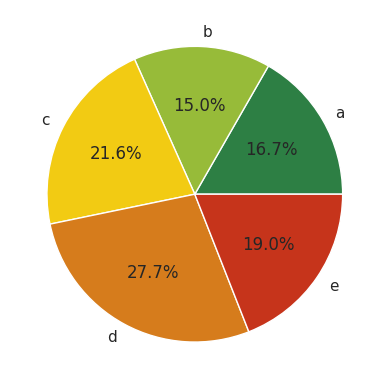

In [ ]:
fig,ax = plt.subplots()
ax.pie(nutriscore_count['count'], labels=nutriscore_count['nutrition_grade_fr'], autopct='%1.1f%%', colors=colors)
plt.show()

In [ ]:
sts.anderson(x=nutriscore['nutrition-score-fr_100g'], dist='norm')

AndersonResult(statistic=586.3541075288813, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=8.661495929964675, scale=9.037967698505698)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

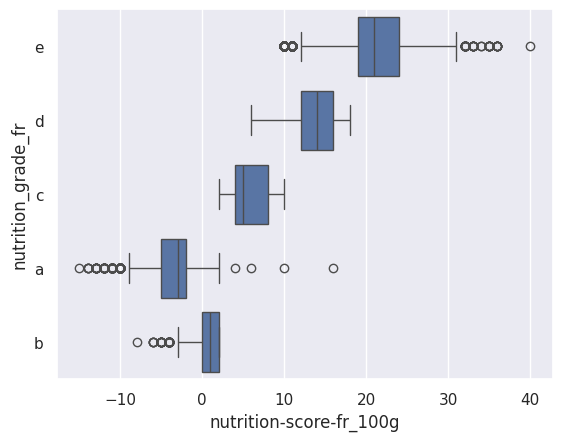

In [ ]:
sns.boxplot(data=nutriscore, x= "nutrition-score-fr_100g", y="nutrition_grade_fr")
plt.xlabel("nutrition-score-fr_100g")
plt.ylabel("nutrition_grade_fr")
plt.show()

Conclusion : Pour chaque groupe, nous rejetons l'hypothèse nulle à 95% de certitudes. Nos distributions ne suivent pas une loi normale.

Nos échantillons sont indépendants et non paramétrique => test de Kruskal-Wallis

H0 = il n’y a pas de corrélation entre nutri_grade et nutri_score.

H1 = il y a une corrélation nutri_grade et nutri_score.

seuil a=0.05

In [ ]:
group_a = nutriscore['nutrition-score-fr_100g'].loc[nutriscore['nutrition_grade_fr'] == 'a']
group_b = nutriscore['nutrition-score-fr_100g'].loc[nutriscore['nutrition_grade_fr'] == 'b']
group_c = nutriscore['nutrition-score-fr_100g'].loc[nutriscore['nutrition_grade_fr'] == 'c']
group_d = nutriscore['nutrition-score-fr_100g'].loc[nutriscore['nutrition_grade_fr'] == 'd']
group_e = nutriscore['nutrition-score-fr_100g'].loc[nutriscore['nutrition_grade_fr'] == 'e']

In [ ]:
kruskal_result = sts.kruskal(group_a, group_b, group_c, group_d, group_e)
print(f'Statistique de Kruskal-Wallis: {kruskal_result.statistic}')
print(f'p-value: {kruskal_result.pvalue}')

Statistique de Kruskal-Wallis: 54614.793656821705
p-value: 0.0


**Conlcusion : On rejette l'hypothèse nulle avec une confiance de plus de 95%. Les différents groupes sont corrélés au nutriscore.**

## PNNS

In [ ]:
df_targetb = df_fr[['pnns_groups_1', 'nutrition-score-fr_100g']]
df_targetb.dropna(inplace=True)
df_targetb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47230 entries, 106 to 320763
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pnns_groups_1            47230 non-null  object 
 1   nutrition-score-fr_100g  47230 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
fig = px.box(df_targetb, x=df_targetb['nutrition-score-fr_100g'], y=df_targetb['pnns_groups_1'], points='all')
fig.update_traces(boxmean=True)
fig.show()

In [ ]:
pnns = df_targetb.loc[df_targetb['pnns_groups_1'] != "unknown"]
pnns = pnns.dropna(subset=["nutrition-score-fr_100g", "pnns_groups_1"])

In [ ]:
pnns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40007 entries, 226 to 320763
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pnns_groups_1            40007 non-null  object 
 1   nutrition-score-fr_100g  40007 non-null  float64
dtypes: float64(1), object(1)
memory usage: 937.7+ KB


In [ ]:
# Vérifier la normalité de chaque groupe
groups = pnns['pnns_groups_1'].unique()
groups = list(groups[1:])
hist_data = []

for group in groups:
  groups_df = pnns.loc[pnns['pnns_groups_1'] == group]['nutrition-score-fr_100g']
  hist_data.append(groups_df.values)

In [ ]:
fig = ff.create_distplot(hist_data, groups, histnorm= '', bin_size=.5)
fig.show()

In [ ]:
# Jeu de données > 5000 individus == Test de Anderson
for group in hist_data:
  print(sts.anderson(x=group, dist='norm'))

AndersonResult(statistic=69.34051785546944, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=17.618434603501544, scale=6.6125365227094335)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=159.97152645514234, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.4685827552031716, scale=5.784805193558263)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=31.896402078293704, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-2.8986658195679795, scale=4.667960499626145)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResu

# Duplicates

In [ ]:
df_fr.shape

(61415, 82)

In [ ]:
df_all = df_fr.copy()
df_all['code'].duplicated().sum()

1

In [ ]:
df_all.drop_duplicates(subset='code', inplace=True)

In [ ]:

df_all = clean_products(df_all,'product_name')
df_all = clean_products(df_all,'brands_tags')

In [ ]:
# drop duplicates
df_all = clean_duplicates(df_all)

Duplicated rows deleted : 4 %


In [ ]:
df_all.shape

(58958, 81)

# Start

In [ ]:
num_col = [col for col in df_all.columns if df_all[col].dtype != object]
df_missing_values_num = display_missing_values(df_all[num_col], 'original%')
pd.set_option('display.max_rows', None)
df_missing_values_num

original%
nutrition-score-fr_100g              0.0000
salt_100g                            0.1306
proteins_100g                        0.1306
sugars_100g                          0.1306
energy_100g                          0.1306
sodium_100g                          0.1306
saturated-fat_100g                   0.1306
fiber_100g                          26.7398
fat_100g                            28.1833
carbohydrates_100g                  28.2698
fruits-vegetables-nuts_100g         95.4102
calcium_100g                        96.7587
vitamin-c_100g                      98.0664
polyunsaturated-fat_100g            98.1766
monounsaturated-fat_100g            98.2055
iron_100g                           98.2343
vitamin-b1_100g                     98.7228
vitamin-e_100g                      98.8178
vitamin-b6_100g                     98.8890
magnesium_100g                      98.9145
vitamin-b9_100g                     98.9263
vitamin-pp_100g                     98.9484
alcohol_100g                        98.9586
cocoa_100g                          98.9772
vitamin-b2_100g                     99.0332
omega-3-fat_100g                    99.0620
vitamin-a_100g                      99.1010
vitamin-d_100g                      99.1299
vitamin-b12_100g                    99.1757
phosphorus_100g                     99.1858
vitamin-b5_100g                     99.3521
cholesterol_100g                    99.3792
trans-fat_100g                      99.4063
polyols_100g                        99.5064
potassium_100g                      99.6031
zinc_100g                           99.6540
vitamin-b8_100g                     99.7201
alpha-linolenic-acid_100g           99.7303
starch_100g                         99.7354
lactose_100g                        99.7744
linoleic-acid_100g                  99.7812
omega-6-fat_100g                    99.8151
iodine_100g                         99.8151
copper_100g                         99.8236
collagen-meat-protein-ratio_100g    99.8287
manganese_100g                      99.8389
selenium_100g                       99.8643
vitamin-k_100g                      99.8931
chloride_100g                       99.9084
fluoride_100g                       99.9288
docosahexaenoic-acid_100g           99.9372
energy-from-fat_100g                99.9491
caffeine_100g                       99.9525
taurine_100g                        99.9593
casein_100g                         99.9593
omega-9-fat_100g                    99.9695
eicosapentaenoic-acid_100g          99.9712
fructose_100g                       99.9729
serum-proteins_100g                 99.9763
bicarbonate_100g                    99.9796
sucrose_100g                        99.9830
maltodextrins_100g                  99.9847
arachidonic-acid_100g               99.9864
beta-carotene_100g                  99.9881
nucleotides_100g                    99.9881
chromium_100g                       99.9898
silica_100g                         99.9898
oleic-acid_100g                     99.9932
molybdenum_100g                     99.9966
maltose_100g                        99.9966
glucose_100g                        99.9966
lauric-acid_100g                    99.9983
gamma-linolenic-acid_100g           99.9983
arachidic-acid_100g                 99.9983

In [ ]:
# TO DELETE
# columns_to_keep = df_missing_values_num[df_missing_values_num['original%'] < 96].index.tolist()
# len(columns_to_keep)

### Subset

In [ ]:
selected_columns = [col for col in df_all.columns if df_all[col].isna().mean() < 0.96]
selected_columns

['code',
 'product_name',
 'brands',
 'serving_size',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'nutrition-score-fr_100g']

<Axes: >

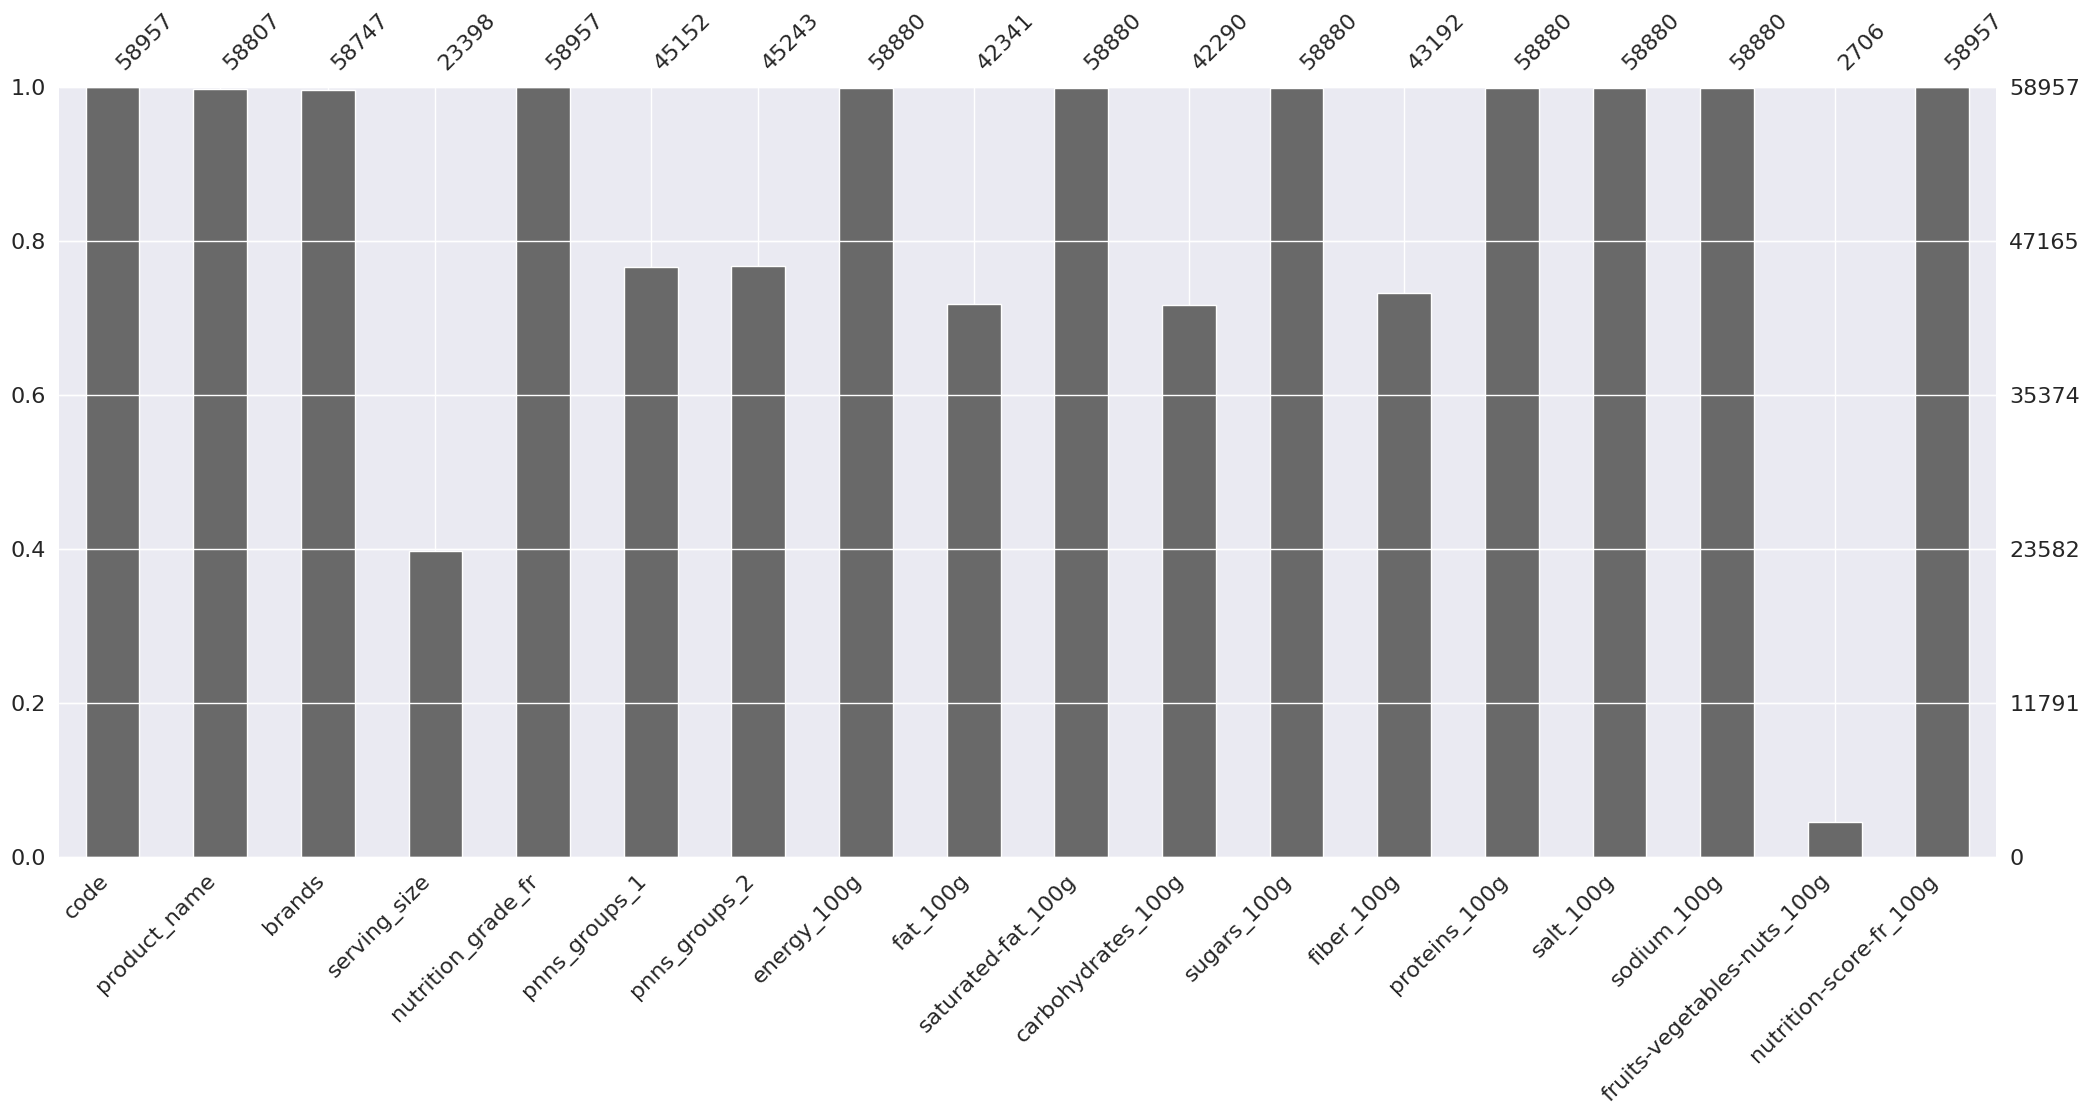

In [ ]:
sns.set()
msno.bar(df_all[selected_columns])

In [ ]:
len(selected_columns)

18

In [ ]:
df_all[selected_columns].describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  5.888000e+04  42341.000000        58880.000000        42290.000000   
mean   1.184665e+03     13.281534            5.451302           27.934873   
std    1.344171e+04     16.596184            8.546496           27.262753   
min    0.000000e+00      0.000000            0.000000            0.000000   
25%    4.390000e+02      1.400000            0.300000            4.200000   
50%    1.042000e+03      7.000000            2.000000           15.000000   
75%    1.657000e+03     21.000000            7.500000           53.000000   
max    3.251373e+06    380.000000          210.000000          190.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g   sodium_100g  \
count  58880.000000  43192.000000   58880.000000  58880.000000  58880.000000   
mean      13.367889      2.559650       7.773746      1.084436      0.426943   
std       18.958342      4.656986       7.855023      3.788805      1.491605   
min       -0.100000      0.000000       0.000000      0.000000      0.000000   
25%        1.000000      0.000000       1.900000      0.080000      0.031496   
50%        4.000000      1.400000       6.000000      0.558800      0.220000   
75%       17.900000      3.200000      10.900000      1.230000      0.484252   
max      104.000000    178.000000     100.000000    211.000000     83.000000   

       fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count                  2706.000000             58957.000000  
mean                     30.111223                 8.661753  
std                      32.230453                 9.040024  
min                       0.000000               -15.000000  
25%                       0.000000                 1.000000  
50%                      17.150000                 9.000000  
75%                      50.000000                15.000000  
max                     100.000000                40.000000

Create Dataframe which will receive the accuracy results

In [ ]:
results_summary = pd.DataFrame({
      'test_name': [],
      'shape': [],
      'accuracy': []})

In [ ]:
results_summary

Empty DataFrame
Columns: [test_name, shape, accuracy]
Index: []

# Cleaning

## Outliers

In [ ]:
main_col = ['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'nutrition-score-fr_100g']

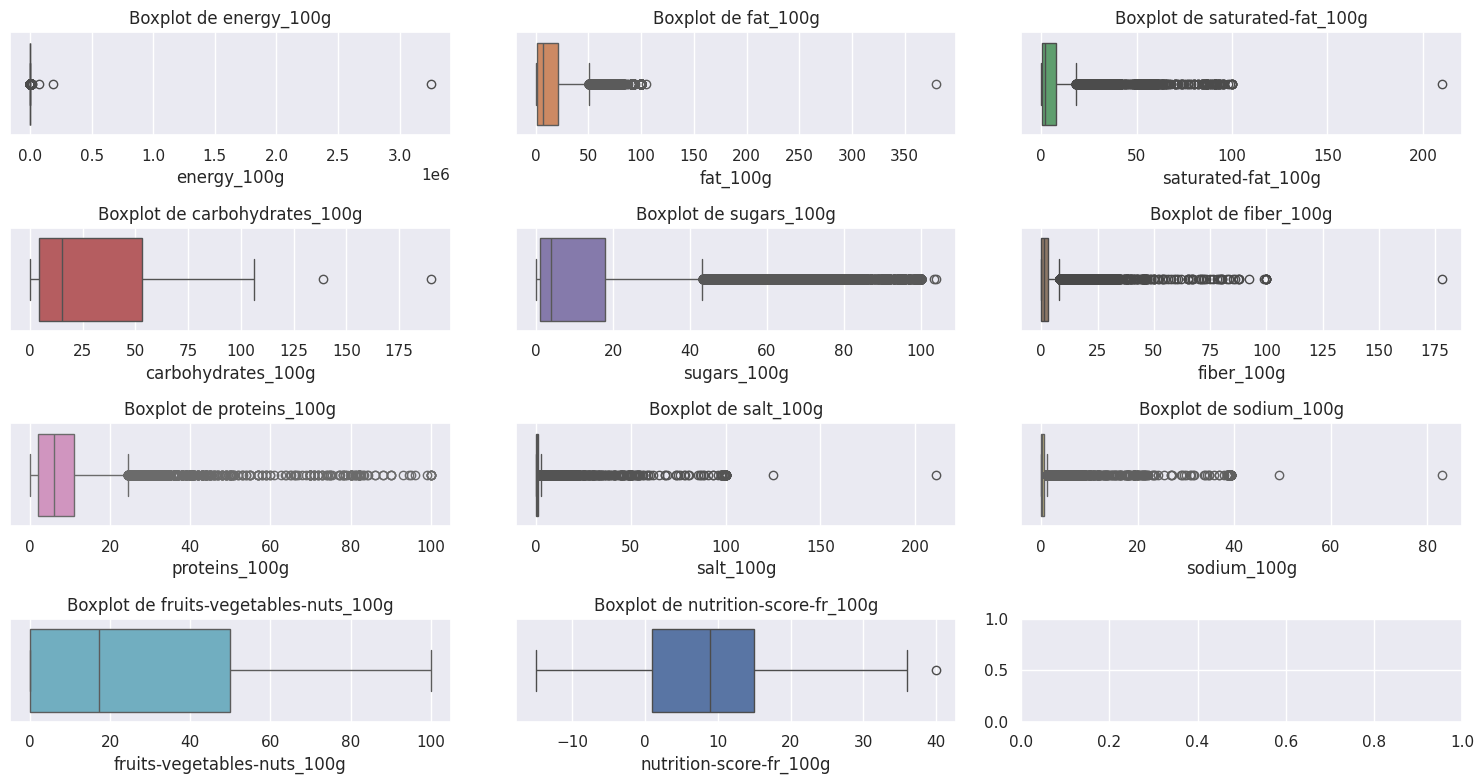

In [ ]:
display_num_boxplt(df_all, main_col)

### Over 100, under 0

In [ ]:
fat_columns = select_columns_between_excluding_end(df_all, "fat_100g", "carbohydrates_100g")
carbs_columns = select_columns_between_excluding_end(df_all, "carbohydrates_100g", "fiber_100g")
clean_outliers(df_all, fat_columns, carbs_columns)

Values replaced with NaN : 155
Values replaced with 0 : 81093


In [ ]:
df_all[selected_columns].describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  5.888000e+04  42339.000000        58831.000000        42285.000000   
mean   1.184665e+03     13.270706            5.440314           27.922981   
std    1.344171e+04     16.494579            8.486431           27.239981   
min    0.000000e+00      0.000000            0.000000            0.000000   
25%    4.390000e+02      1.400000            0.300000            4.200000   
50%    1.042000e+03      7.000000            2.000000           15.000000   
75%    1.657000e+03     21.000000            7.500000           53.000000   
max    3.251373e+06    100.000000          100.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g   sodium_100g  \
count  58789.000000  43191.000000   58880.000000  58878.000000  58880.000000   
mean      13.359045      2.555588       7.773746      1.078766      0.426943   
std       18.943779      4.579886       7.855023      3.653256      1.491605   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        1.000000      0.000000       1.900000      0.080000      0.031496   
50%        4.000000      1.400000       6.000000      0.558800      0.220000   
75%       17.900000      3.200000      10.900000      1.230000      0.484252   
max      100.000000    100.000000     100.000000    100.000000     83.000000   

       fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count                  2706.000000             58957.000000  
mean                     30.111223                 8.661753  
std                      32.230453                 9.040024  
min                       0.000000               -15.000000  
25%                       0.000000                 1.000000  
50%                      17.150000                 9.000000  
75%                      50.000000                15.000000  
max                     100.000000                40.000000

### Using IQ

In [ ]:
clean_with_iq(df_all, 'energy_100g')

energy_100g values replaced with NaN : 423


In [ ]:
df_all.loc[df_all['vitamin-c_100g'] > 1, 'vitamin-c_100g'] = np.nan
df_all.loc[df_all['calcium_100g'] > 10, 'calcium_100g'] = np.nan
df_all.loc[df_all['iron_100g'] > 0.1, 'iron_100g'] = np.nan

In [ ]:
clean_with_iq(df_all, 'fiber_100g')

fiber_100g values replaced with NaN : 2762


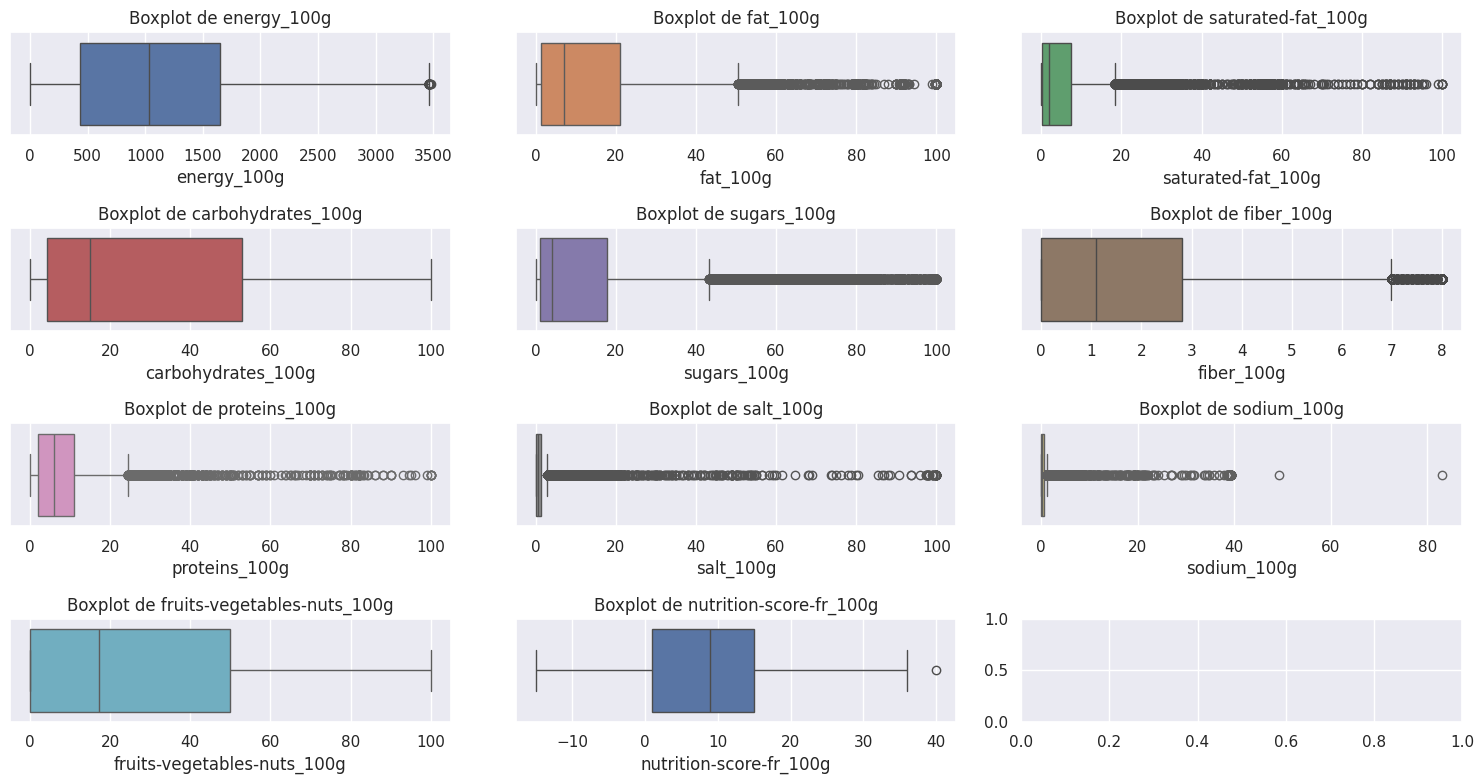

In [ ]:
display_num_boxplt(df_all, main_col)

In [ ]:
# df_all.loc[df_all['cholesterol_100g'] > 5, 'trans-fat_100g'] = np.nan
# df_all.loc[df_all['cholesterol_100g'] > 10, 'cholesterol_100g'] = np.nan

### Sum main compnents greater than 100g

In [ ]:
columns_to_count = ['fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

df_num = delete_nonsense_rows(df_all, columns_to_count)

Rows deleted = 302


In [ ]:
df_all[selected_columns].describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  58457.000000  42339.000000        58831.000000        42285.000000   
mean    1104.061562     13.270706            5.440314           27.922981   
std      744.877937     16.494579            8.486431           27.239981   
min        0.000000      0.000000            0.000000            0.000000   
25%      435.000000      1.400000            0.300000            4.200000   
50%     1036.000000      7.000000            2.000000           15.000000   
75%     1646.000000     21.000000            7.500000           53.000000   
max     3477.000000    100.000000          100.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g   sodium_100g  \
count  58789.000000  40429.000000   58880.000000  58878.000000  58880.000000   
mean      13.359045      1.737405       7.773746      1.078766      0.426943   
std       18.943779      1.963978       7.855023      3.653256      1.491605   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        1.000000      0.000000       1.900000      0.080000      0.031496   
50%        4.000000      1.100000       6.000000      0.558800      0.220000   
75%       17.900000      2.800000      10.900000      1.230000      0.484252   
max      100.000000      8.000000     100.000000    100.000000     83.000000   

       fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count                  2706.000000             58957.000000  
mean                     30.111223                 8.661753  
std                      32.230453                 9.040024  
min                       0.000000               -15.000000  
25%                       0.000000                 1.000000  
50%                      17.150000                 9.000000  
75%                      50.000000                15.000000  
max                     100.000000                40.000000

In [ ]:
display_missing_values(df_all, 'after_outliers%', df_missing_values_num)
df_missing_values_num.sort_values(by='after_outliers%')


original%  after_outliers%
nutrition-score-fr_100g              0.0000           0.0000
proteins_100g                        0.1306           0.1306
sodium_100g                          0.1306           0.1306
salt_100g                            0.1306           0.1340
saturated-fat_100g                   0.1306           0.2137
sugars_100g                          0.1306           0.2850
energy_100g                          0.1306           0.8481
fat_100g                            28.1833          28.1866
carbohydrates_100g                  28.2698          28.2782
fiber_100g                          26.7398          31.4263
polyunsaturated-fat_100g            98.1766          92.6353
monounsaturated-fat_100g            98.2055          92.6658
omega-3-fat_100g                    99.0620          93.5156
cholesterol_100g                    99.3792          93.9176
trans-fat_100g                      99.4063          93.9413
alpha-linolenic-acid_100g           99.7303          94.1839
linoleic-acid_100g                  99.7812          94.2331
omega-6-fat_100g                    99.8151          94.2670
docosahexaenoic-acid_100g           99.9372          94.3891
omega-9-fat_100g                    99.9695          94.4214
eicosapentaenoic-acid_100g          99.9712          94.4231
arachidonic-acid_100g               99.9864          94.4383
oleic-acid_100g                     99.9932          94.4451
lauric-acid_100g                    99.9983          94.4502
gamma-linolenic-acid_100g           99.9983          94.4502
arachidic-acid_100g                 99.9983          94.4502
fruits-vegetables-nuts_100g         95.4102          95.4102
polyols_100g                        99.5064          96.5924
calcium_100g                        96.7587          96.7620
starch_100g                         99.7354          96.8180
lactose_100g                        99.7744          96.8570
fructose_100g                       99.9729          97.0555
sucrose_100g                        99.9830          97.0640
maltodextrins_100g                  99.9847          97.0657
maltose_100g                        99.9966          97.0775
glucose_100g                        99.9966          97.0775
vitamin-c_100g                      98.0664          98.0698
iron_100g                           98.2343          98.2479
vitamin-b1_100g                     98.7228          98.7245
vitamin-e_100g                      98.8178          98.8178
vitamin-b6_100g                     98.8890          98.8890
magnesium_100g                      98.9145          98.9145
vitamin-b9_100g                     98.9263          98.9263
vitamin-pp_100g                     98.9484          98.9484
alcohol_100g                        98.9586          98.9586
cocoa_100g                          98.9772          98.9772
vitamin-b2_100g                     99.0332          99.0332
vitamin-a_100g                      99.1010          99.1010
vitamin-d_100g                      99.1299          99.1299
vitamin-b12_100g                    99.1757          99.1757
phosphorus_100g                     99.1858          99.1858
vitamin-b5_100g                     99.3521          99.3521
potassium_100g                      99.6031          99.6031
zinc_100g                           99.6540          99.6540
vitamin-b8_100g                     99.7201          99.7201
iodine_100g                         99.8151          99.8151
copper_100g                         99.8236          99.8236
collagen-meat-protein-ratio_100g    99.8287          99.8287
manganese_100g                      99.8389          99.8389
selenium_100g                       99.8643          99.8643
vitamin-k_100g                      99.8931          99.8931
chloride_100g                       99.9084          99.9084
fluoride_100g                       99.9288          99.9288
energy-from-fat_100g                99.9491          99.9491
caffeine_100g                       99.9525          99.9525
taurine_

In [ ]:
# selected_columns = []
# for col in df_all.select_dtypes(include='float64').columns.tolist():
#   if df_all[col].notna().sum() >= 1000:
#     selected_columns.append(col)
#   if df_all[col].notna().sum() <= 500:
#     df_all.drop(columns=col, inplace=True)

In [ ]:
# with_target = main_col + ['nutrition_grade_fr']

# Correlations

We create a copy of df_all where we'll impute missing values

In [ ]:
df_imputed = df_all.copy(deep=True)

In [ ]:
df_imputed.head()

code                             product_name        brands  \
235743  3501430000129           Mogettes cuisinees a la tomate         01vac   
237726  3560070193943                          Nectar d'Orange             1   
248244  3609761400219       Sauce Tomate Olive Méditerranéenne     1.2.3.BIO   
248585  3660668001978         Jus d'orange à base de concentré  1 2 3 Fruits   
248587  3660668002005  Jus de pamplemousse à base de concentré  1 2 3 Fruits   

       serving_size nutrition_grade_fr   pnns_groups_1         pnns_groups_2  \
235743          NaN                  a         unknown               unknown   
237726        20 cl                  d       Beverages         Fruit nectars   
248244          NaN                  c  Fat and sauces  Dressings and sauces   
248585         25cl                  c       Beverages          Fruit juices   
248587          NaN                  b       Beverages          Fruit juices   

        energy_100g  energy-from-fat_100g  fat_100g  saturated-fat_100g  \
235743        272.0                   NaN      0.60                0.10   
237726         85.0                   NaN      0.03                0.01   
248244        292.0                   NaN      4.40                0.70   
248585        205.0                   NaN      0.00                0.00   
248587        138.0                   NaN      0.10                0.00   

        lauric-acid_100g  arachidic-acid_100g  monounsaturated-fat_100g  \
235743               NaN                  NaN                       NaN   
237726               NaN                  NaN                       NaN   
248244               NaN                  NaN                       NaN   
248585               0.0                  0.0                       0.0   
248587               NaN                  NaN                       NaN   

        polyunsaturated-fat_100g  omega-3-fat_100g  alpha-linolenic-acid_100g  \
235743                       NaN               NaN                        NaN   
237726                       NaN               NaN                        NaN   
248244                       NaN               NaN                        NaN   
248585                       0.0               0.0                        0.0   
248587                       NaN               NaN                        NaN   

        eicosapentaenoic-acid_100g  docosahexaenoic-acid_100g  \
235743                         NaN                        NaN   
237726                         NaN                        NaN   
248244                         NaN                        NaN   
248585                         0.0                        0.0   
248587                         NaN                        NaN   

        omega-6-fat_100g  linoleic-acid_100g  arachidonic-acid_100g  \
235743               NaN                 NaN                    NaN   
237726               NaN                 NaN                    NaN   
248244               NaN                 NaN                    NaN   
248585               0.0                 0.0                    0.0   
248587               NaN                 NaN                    NaN   

        gamma-linolenic-acid_100g  omega-9-fat_100g  oleic-acid_100g  \
235743                        NaN               NaN              NaN   
237726                        NaN               NaN              NaN   
248244                        NaN               NaN              NaN   
248585                        0.0               0.0              0.0   
248587                        NaN               NaN              NaN   

        trans-fat_100g  cholesterol_100g  carbohydrates_100g  sugars_100g  \
235743             NaN               NaN                 8.6          0.4   
237726             NaN               NaN                 4.7          4.7   
248244             NaN               NaN                 5.7          3.4   
248585             0.0               0.0                11.0         11.0   
248587             NaN        

In [ ]:
main_col = ['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'nutrition-score-fr_100g']

<Axes: >

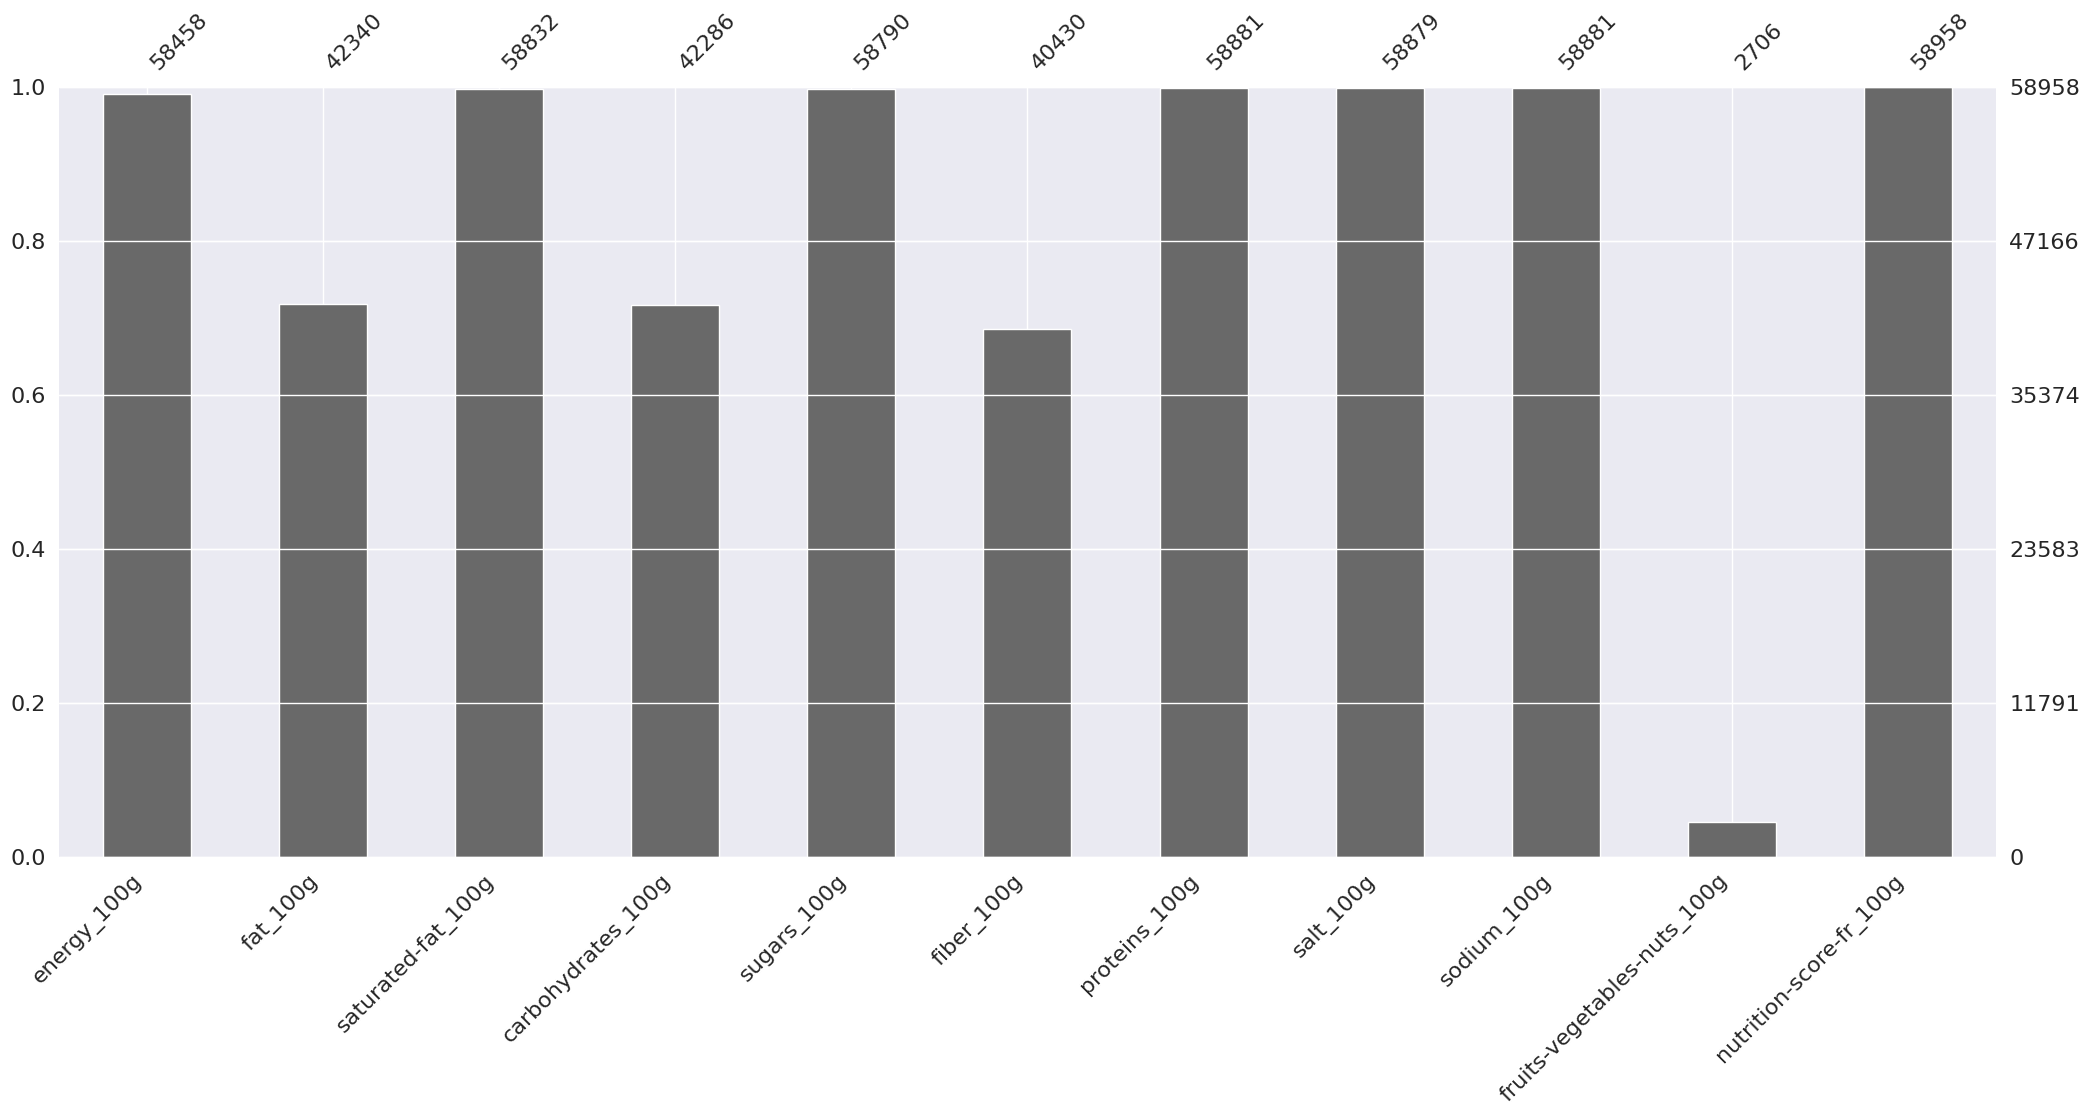

In [ ]:
sns.set()
msno.bar(df_imputed[main_col])

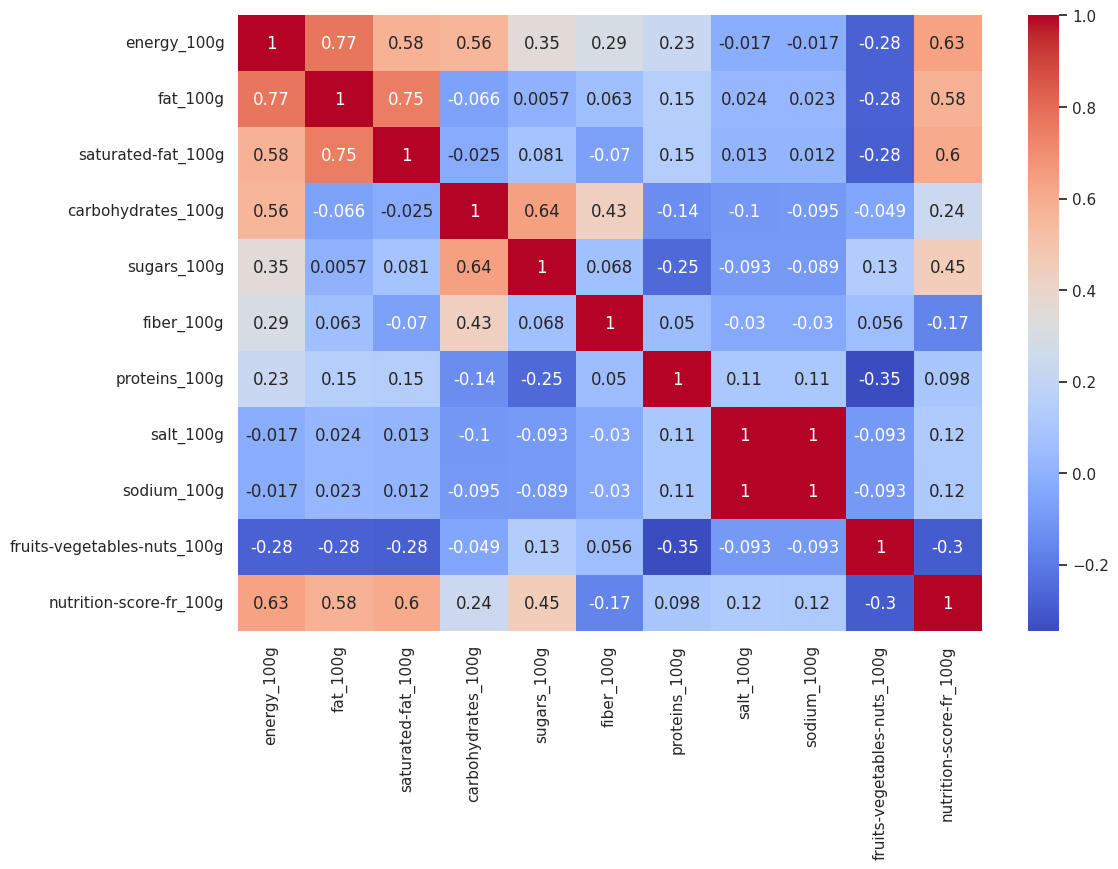

In [ ]:
display_corr(df_imputed, main_col)

In [ ]:
# Sodium and salt correlated
main_col.remove('sodium_100g')

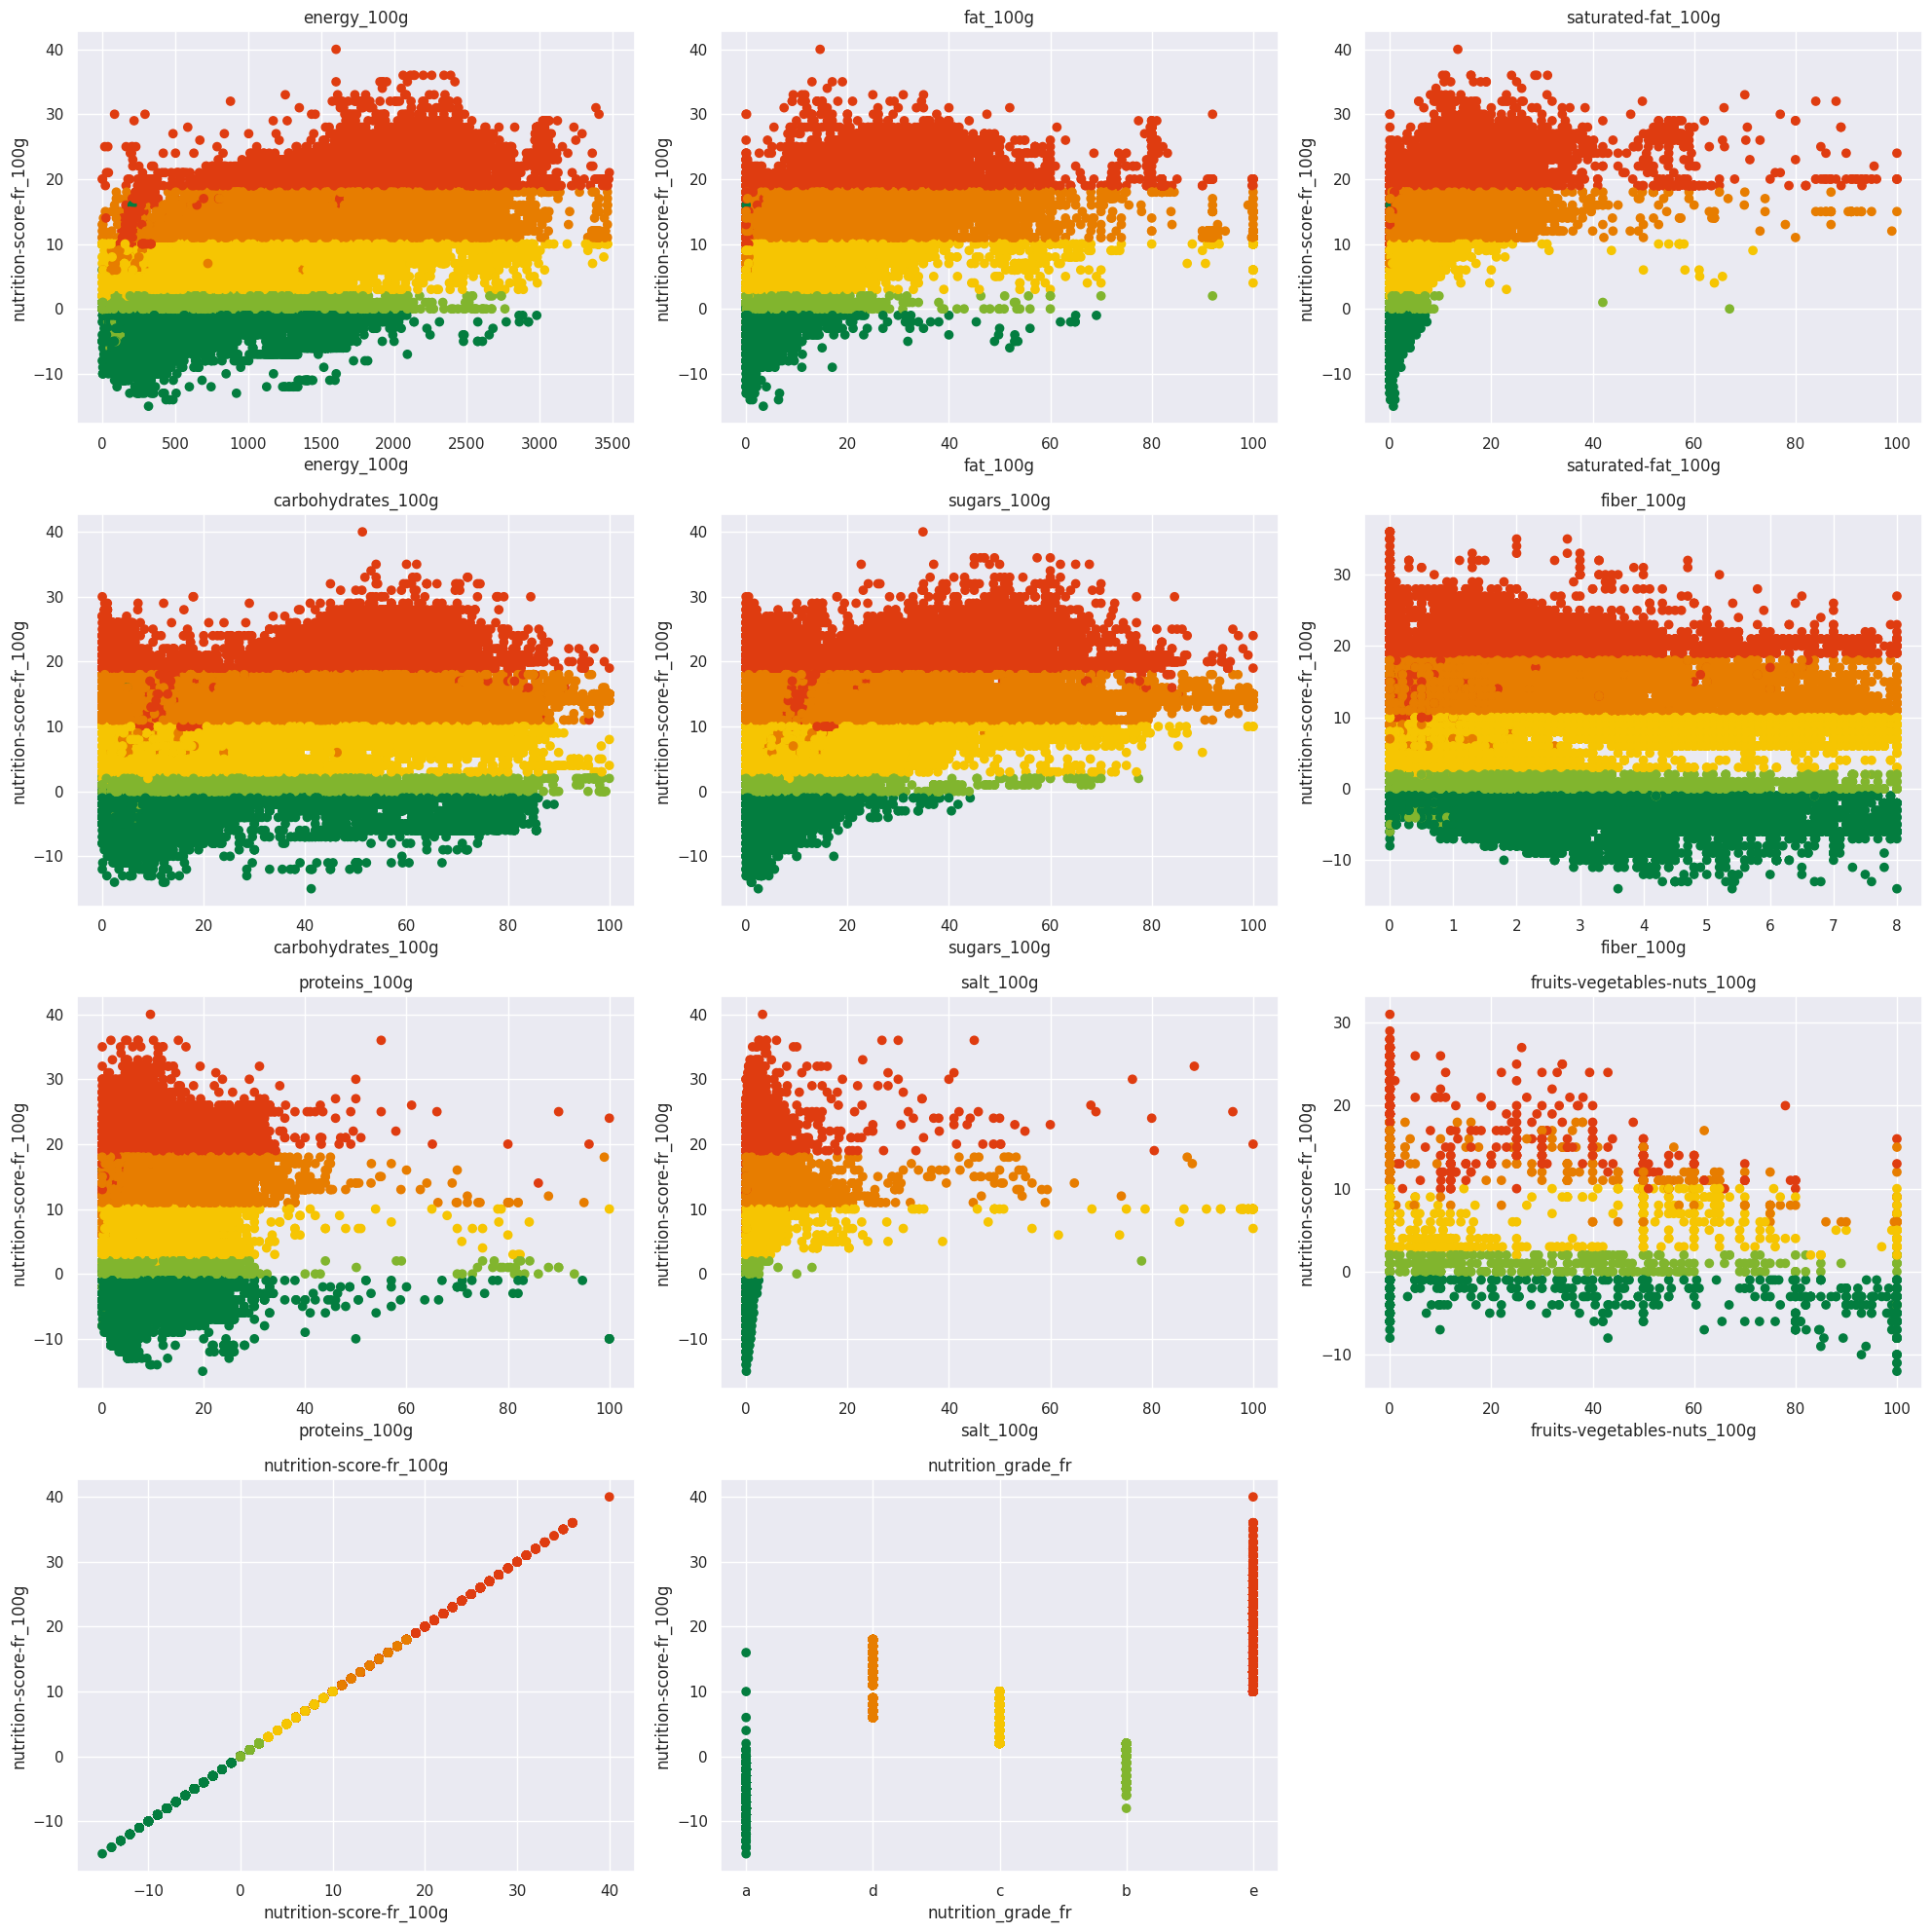

In [ ]:
# colors
colors = ['#037D3F', '#81B52E', '#F6C502', '#E77D00',  '#DF3C10']

nutrition_grades = ['a', 'b', 'c', 'd', 'e']
color_map = dict(zip(nutrition_grades, colors))

# Convertir les grades en couleurs
df_imputed['color'] = df_imputed['nutrition_grade_fr'].map(color_map)

plt.figure(figsize=(20, 20))
for i, col in enumerate(main_col + ["nutrition_grade_fr"]):
    plt.subplot(4, 3, i+1)
    plt.scatter(df_imputed[col], df_imputed['nutrition-score-fr_100g'], c=df_imputed['color'])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('nutrition-score-fr_100g')
plt.tight_layout()
plt.show()


# Mainly correlated to Nutrition Score but not correlated together

In [ ]:
main_columns = ["energy_100g", "saturated-fat_100g", "sugars_100g"]

## KNN imputer

In [ ]:
df_main_corr, best_n_neighbors = test_subset(["energy_100g", "saturated-fat_100g", "sugars_100g"], df_imputed, scaler=StandardScaler())

 test df shape : (58325, 3)
before normalization
        energy_100g  saturated-fat_100g   sugars_100g
count  58325.000000        58325.000000  58325.000000
mean    1104.258874            5.349111     13.411557
std      744.883993            8.207807     18.943497
min        0.000000            0.000000      0.000000
25%      435.000000            0.300000      1.000000
50%     1036.000000            2.000000      4.100000
75%     1647.000000            7.300000     18.000000
max     3477.000000          100.000000    100.000000
after normalization
        energy_100g  saturated-fat_100g   sugars_100g
count  11665.000000        11665.000000  11665.000000
mean      -0.000770           -0.008458      0.005387
std        0.952105            0.935738      0.933491
min       -1.485260           -0.652422     -0.709165
25%       -0.844388           -0.603625     -0.629849
50%       -0.030198           -0.371839     -0.423629
75%        0.682778            0.205591      0.279635
max        3.

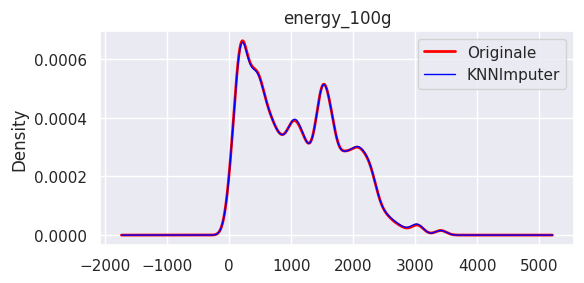

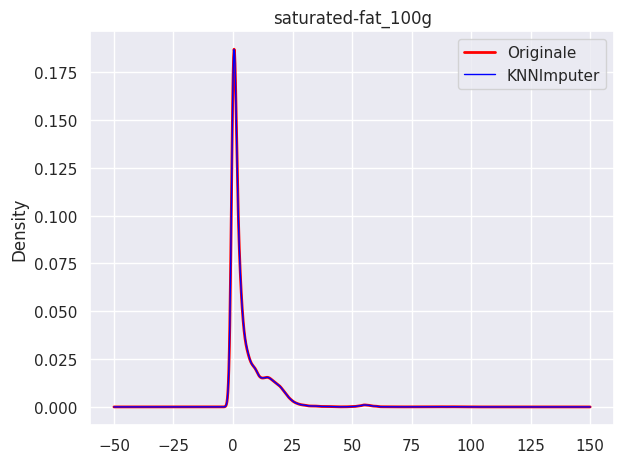

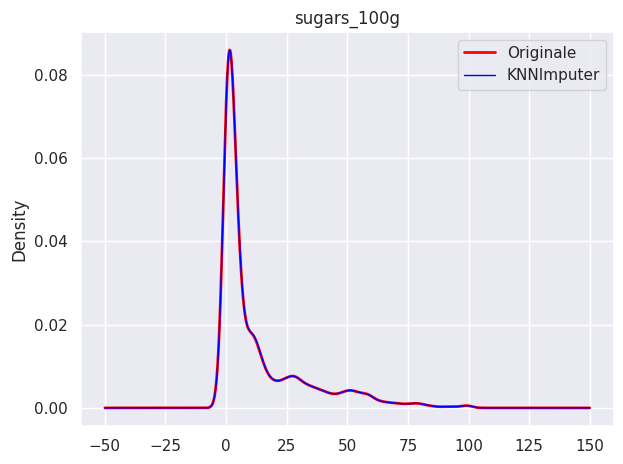

In [ ]:
df_main_corr_knn = impute_and_check(KNNImputer(n_neighbors=best_n_neighbors), main_columns,df_imputed, 'KNNImputer')

In [ ]:
df_main_corr_knn[main_columns].describe() - df_imputed[main_columns].describe()

energy_100g  saturated-fat_100g  sugars_100g
count   500.000000          126.000000   168.000000
mean      4.802434            0.002807     0.001047
std       2.066735           -0.002148    -0.015835
min       0.000000            0.000000     0.000000
25%       4.000000            0.000000     0.000000
50%       5.000000            0.000000     0.005000
75%       4.000000           -0.032500    -0.100000
max       0.000000            0.000000     0.000000

## Iterative imputer

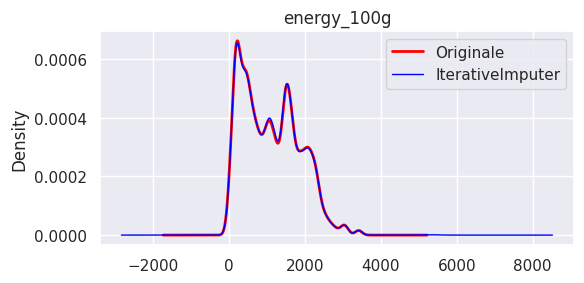

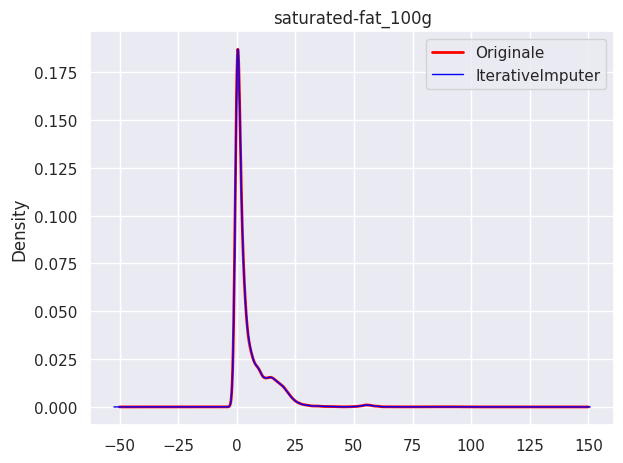

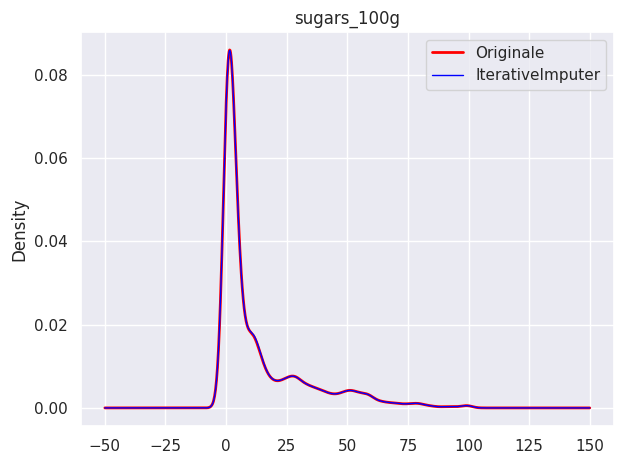

In [ ]:
df_fat_iterative = impute_and_check(IterativeImputer(), fat_columns, df_imputed, 'IterativeImputer')

In [ ]:
df_main_corr_knn.describe() - df_imputed[fat_columns].describe()

energy_100g  saturated-fat_100g  sugars_100g
count   500.000000          126.000000   168.000000
mean      3.893970            0.000363    -0.002901
std       4.716318           -0.007720    -0.025306
min       0.000000           -1.599194     0.000000
25%       4.000000            0.000000     0.000000
50%       6.000000            0.000000     0.100000
75%      -2.000000           -0.100000    -0.100000
max    2204.761757            0.000000     0.000000

## Imputations

We impute fat and saturated_fat using KNN imputer (n = 5) and omega 3 using iterative imputer.

In [ ]:
df_imputed[main_columns] = df_main_corr_knn[main_columns]

In [ ]:
display_missing_values(df_imputed, 'first_imputation%', df_missing_values_num)
df_missing_values_num.sort_values(by='first_imputation%')

original%  after_outliers%  \
nutrition-score-fr_100g              0.0000           0.0000   
sugars_100g                          0.1306           0.2849   
energy_100g                          0.1306           0.8481   
saturated-fat_100g                   0.1306           0.2137   
proteins_100g                        0.1306           0.1306   
sodium_100g                          0.1306           0.1306   
salt_100g                            0.1306           0.1340   
fat_100g                            28.1828          28.1862   
carbohydrates_100g                  28.2693          28.2778   
fiber_100g                          26.7394          31.4258   
polyunsaturated-fat_100g            98.1767          92.6354   
monounsaturated-fat_100g            98.2055          92.6660   
omega-3-fat_100g                    99.0620          93.5157   
cholesterol_100g                    99.3792          93.9177   
trans-fat_100g                      99.4064          93.9414   
alpha-linolenic-acid_100g           99.7303          94.1840   
linoleic-acid_100g                  99.7812          94.2332   
omega-6-fat_100g                    99.8151          94.2671   
docosahexaenoic-acid_100g           99.9372          94.3892   
omega-9-fat_100g                    99.9695          94.4215   
eicosapentaenoic-acid_100g          99.9712          94.4231   
arachidonic-acid_100g               99.9864          94.4384   
oleic-acid_100g                     99.9932          94.4452   
lauric-acid_100g                    99.9983          94.4503   
gamma-linolenic-acid_100g           99.9983          94.4503   
arachidic-acid_100g                 99.9983          94.4503   
fruits-vegetables-nuts_100g         95.4103          95.4103   
polyols_100g                        99.5064          96.5925   
calcium_100g                        96.7587          96.7621   
starch_100g                         99.7354          96.8181   
lactose_100g                        99.7744          96.8571   
fructose_100g                       99.9729          97.0555   
sucrose_100g                        99.9830          97.0640   
maltodextrins_100g                  99.9847          97.0657   
maltose_100g                        99.9966          97.0776   
glucose_100g                        99.9966          97.0776   
vitamin-c_100g                      98.0664          98.0698   
iron_100g                           98.2343          98.2479   
vitamin-b1_100g                     98.7228          98.7245   
vitamin-e_100g                      98.8178          98.8178   
vitamin-b6_100g                     98.8890          98.8890   
magnesium_100g                      98.9145          98.9145   
vitamin-b9_100g                     98.9264          98.9264   
vitamin-pp_100g                     98.9484          98.9484   
alcohol_100g                        98.9586          98.9586   
cocoa_100g                          98.9772          98.9772   
vitamin-b2_100g                     99.0332          99.0332   
vitamin-a_100g                      99.1011          99.1011   
vitamin-d_100g                      99.1299          99.1299   
vitamin-b12_100g                    99.1757          99.1757   
phosphorus_100g                     99.1859          99.1859   
vitamin-b5_100g                     99.3521          99.3521   
potassium_100g                      99.6031          99.6031   
zinc_100g                           99.6540          99.6540   
vitamin-b8_100g                     99.7201          99.7201   
iodine_100g                         99.8151          99.8151   
copper_100g                         99.8236          99.8236   
collagen-meat-protein-ratio_100g    99.8287          99.8287   
manganese_100g                      99.8389          99.8389   
selenium_100g                       99.8643          99.8643   
vitamin-k_100g                      99.8931          99.8931   
chloride_100g                       99.9084          99.9084   
fl

# First imputation, according to nutrition score most correlated variables

In [ ]:
accuracy = predict_grade(main_columns, df_imputed)
results_summary = results_summary._append({'test_name': f'{len(main_columns)} main variables', 'shape': df_imputed[main_columns].shape, 'accuracy': accuracy}, ignore_index=True)
results_summary

(58958, 4)

test_name       shape  accuracy
0  3 main variables  (58958, 3)  0.693691

# Fibers

## PNNS 2

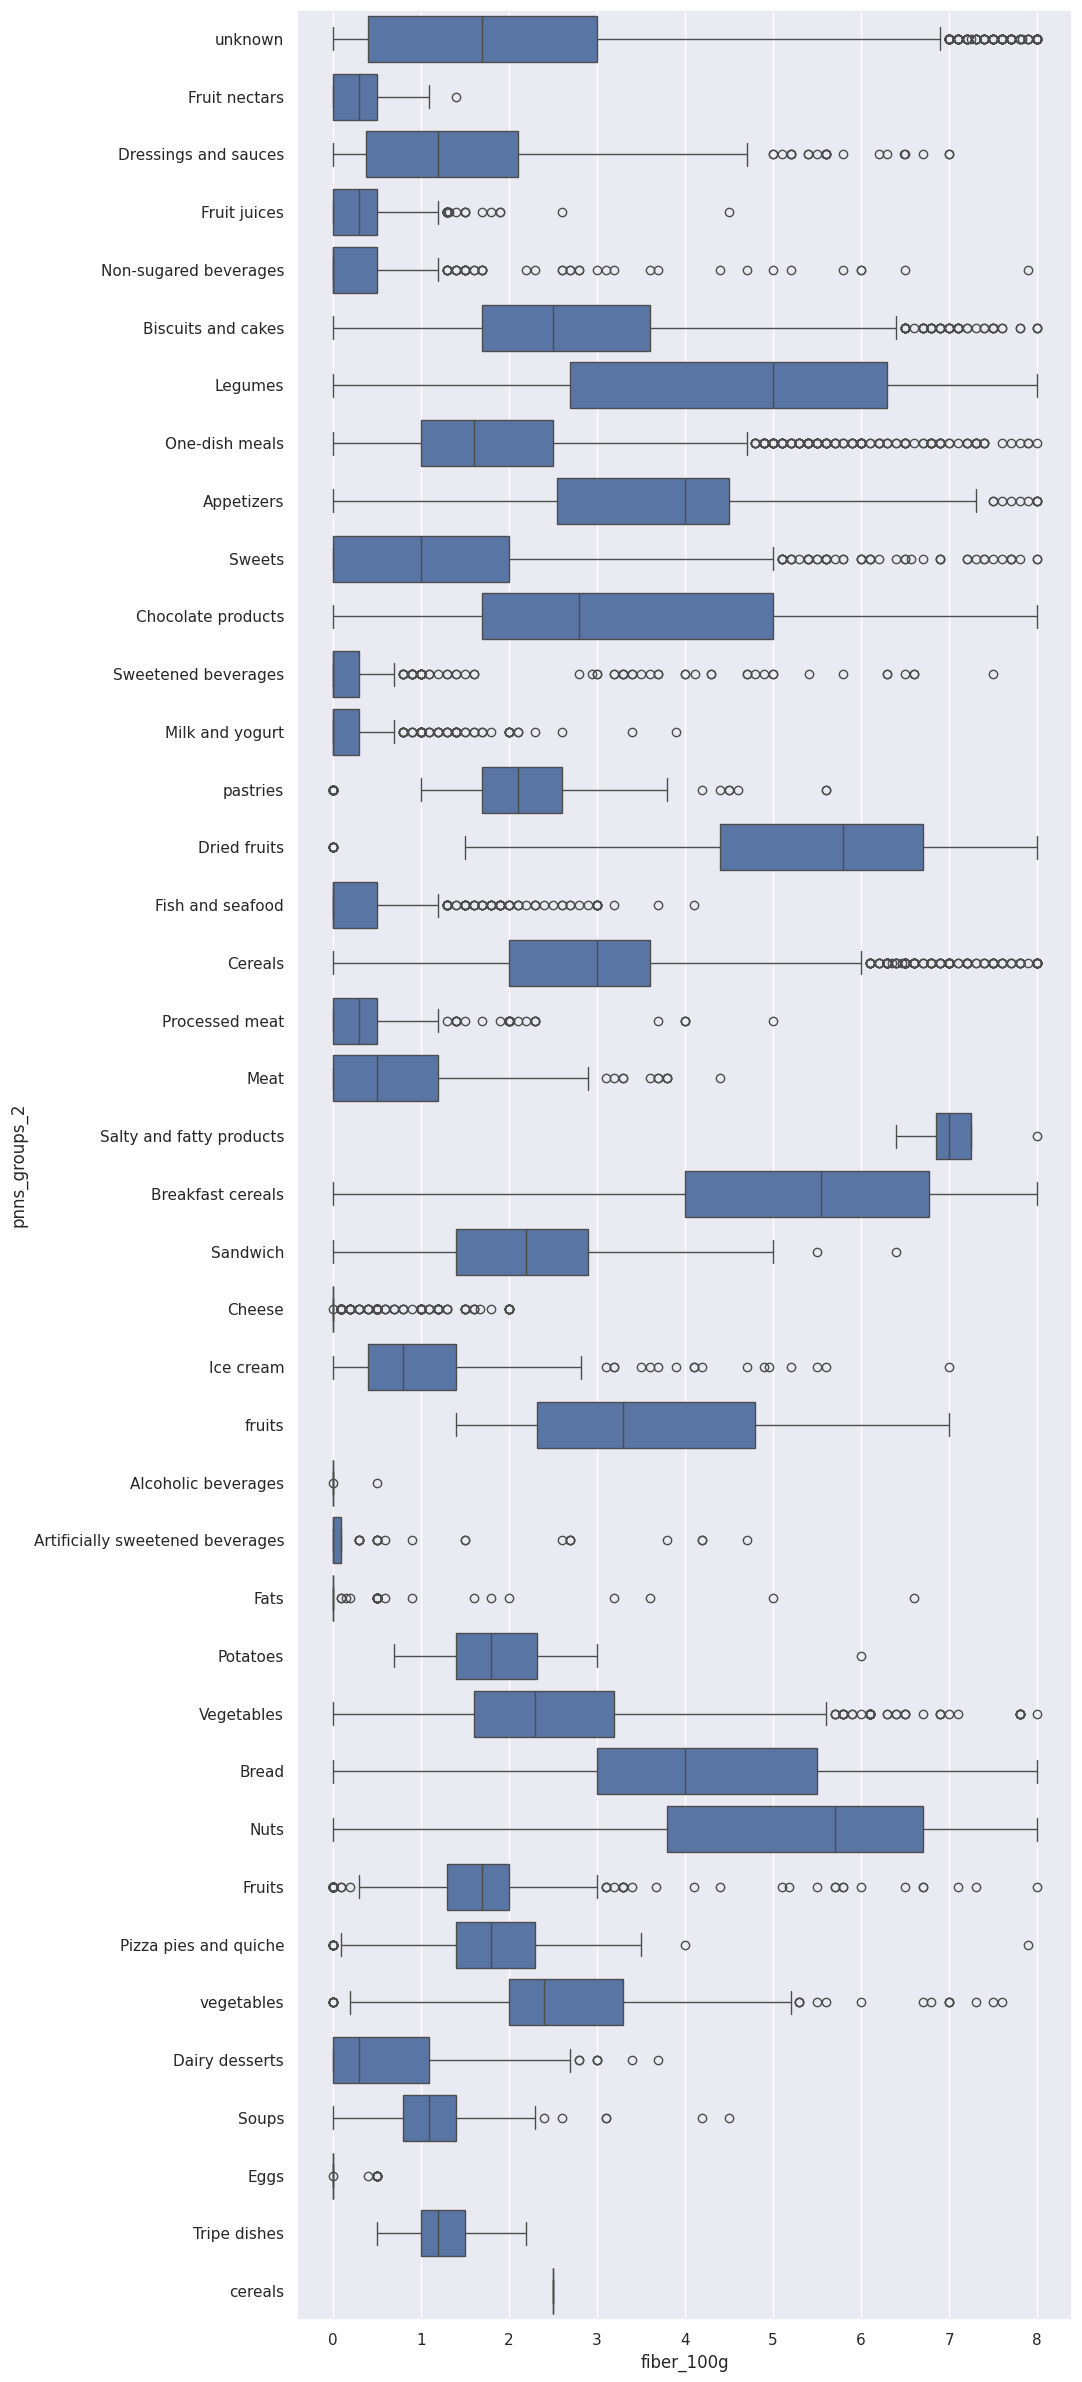

In [ ]:
groupby_pnns = df_imputed.copy()

fig, ax = plt.subplots(figsize=(10,30))
sns.boxplot(ax=ax, y='pnns_groups_2', x='fiber_100g', data=groupby_pnns)

plt.show()

In [ ]:
test_fiber = df_imputed.copy()

In [ ]:
replace_with_pnns_stats(test_fiber, 'pnns_groups_2', 'fiber_100g', "median")

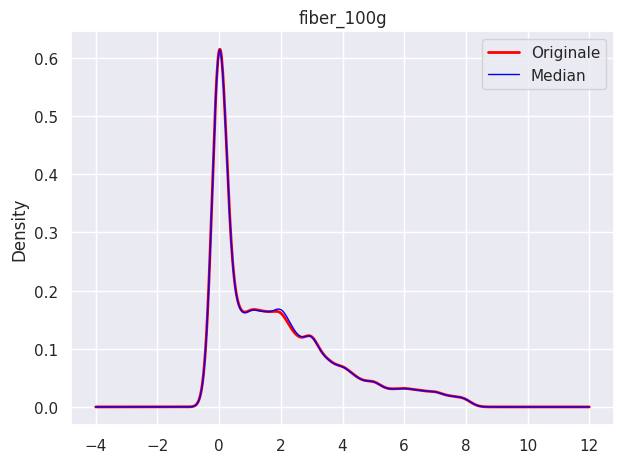

In [ ]:
df_imputed['fiber_100g'].plot(kind="kde", c="red", label='Original', linewidth=2)
test_fiber['fiber_100g'].plot(kind="kde", c="blue", label='mean', linewidth=1)

labels = ["Originale", 'Median']
plt.legend(labels)
plt.title('fiber_100g')
plt.tight_layout()
plt.show()

In [ ]:
test_fiber['fiber_100g'].describe() - df_imputed['fiber_100g'].describe()

count    227.000000
mean       0.002484
std       -0.005181
min        0.000000
25%        0.000000
50%        0.100000
75%        0.000000
max        0.000000
Name: fiber_100g, dtype: float64

In [ ]:
replace_with_pnns_stats(df_imputed, 'pnns_groups_2', 'fiber_100g', method="median")

In [ ]:
df_imputed['fiber_100g'].isna().sum()

18301

## Rest of Nutrition score related variables


In [ ]:
nut_score = ["energy_100g", "saturated-fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "fruits-vegetables-nuts_100g"]

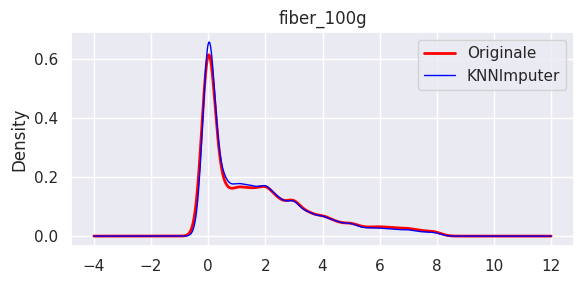

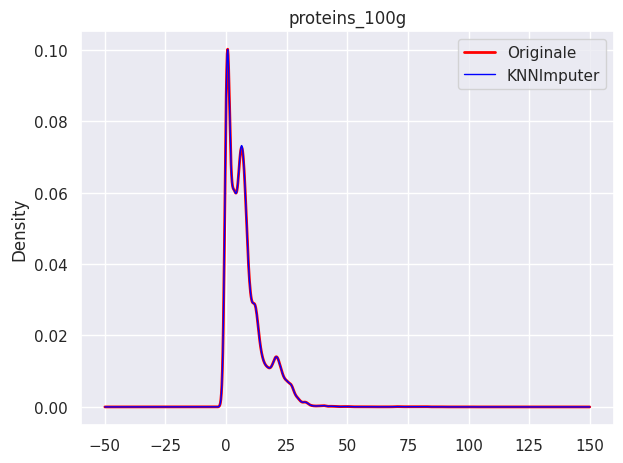

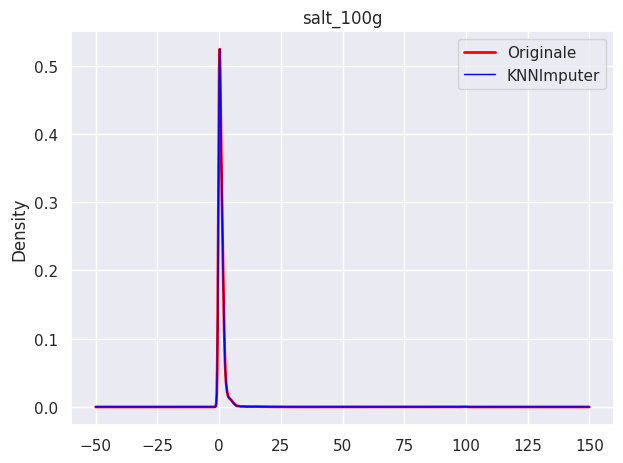

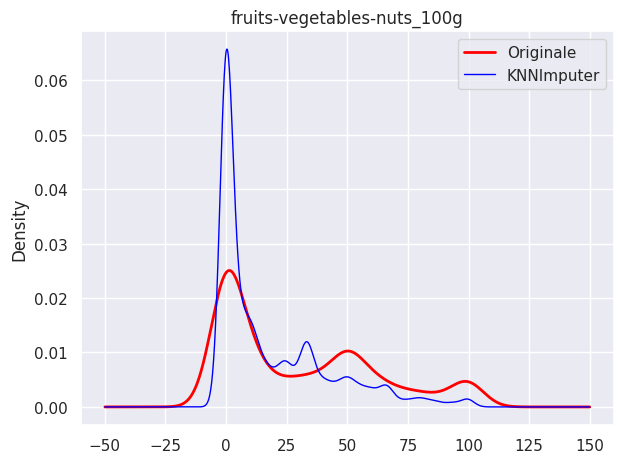

In [ ]:
knn_corr_score = impute_and_check(KNNImputer(n_neighbors=3), nut_score, df_imputed, 'KNNImputer', to_display=["fiber_100g", "proteins_100g", "salt_100g", "fruits-vegetables-nuts_100g"])

In [ ]:
knn_corr_score[["fiber_100g", "proteins_100g", "salt_100g", "fruits-vegetables-nuts_100g"]].describe() - df_imputed[["fiber_100g", "proteins_100g", "salt_100g", "fruits-vegetables-nuts_100g"]].describe()

fiber_100g  proteins_100g  salt_100g  fruits-vegetables-nuts_100g
count  18301.000000      77.000000  79.000000                 56252.000000
mean      -0.070515      -0.001751  -0.000327                   -11.908724
std       -0.094915      -0.004982  -0.002436                    -8.616394
min        0.000000       0.000000   0.000000                     0.000000
25%        0.000000       0.085000   0.000000                     0.000000
50%       -0.100000       0.000000   0.000000                   -10.116667
75%       -0.133333       0.000000  -0.000980                   -16.833333
max        0.000000       0.000000   0.000000                     0.000000

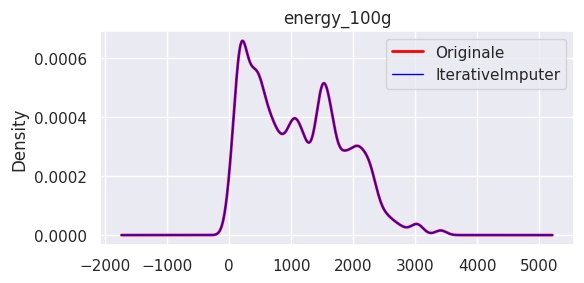

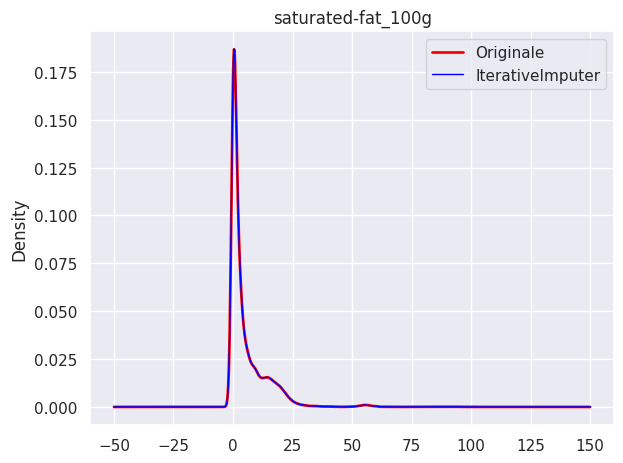

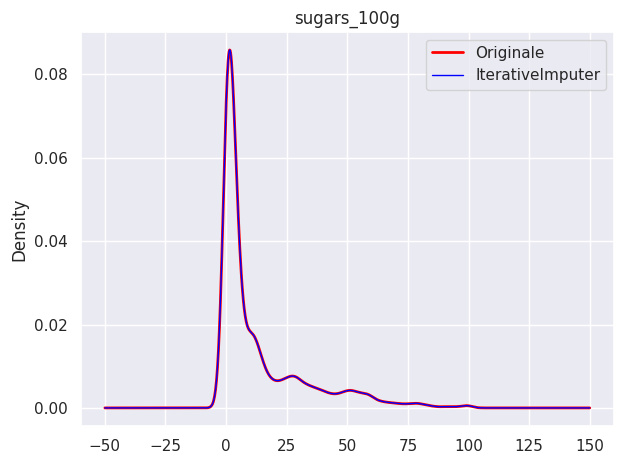

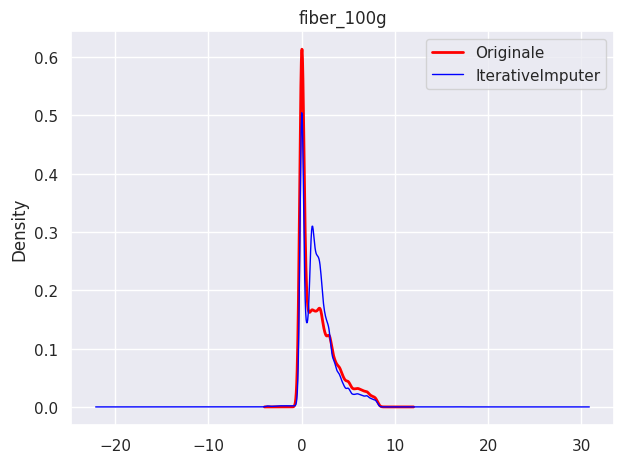

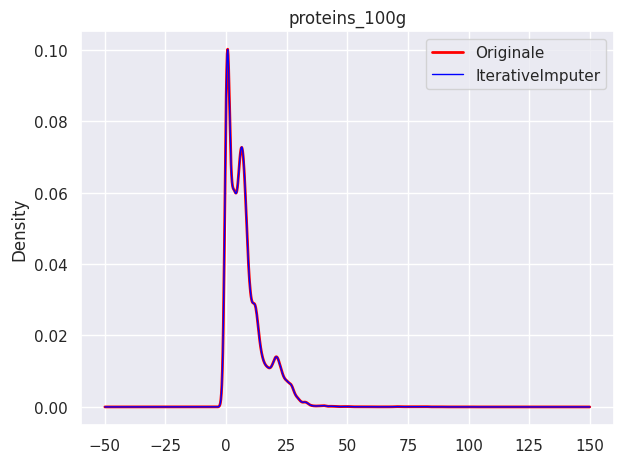

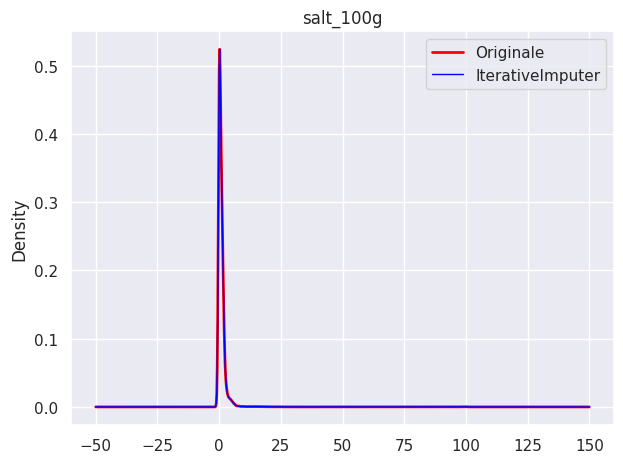

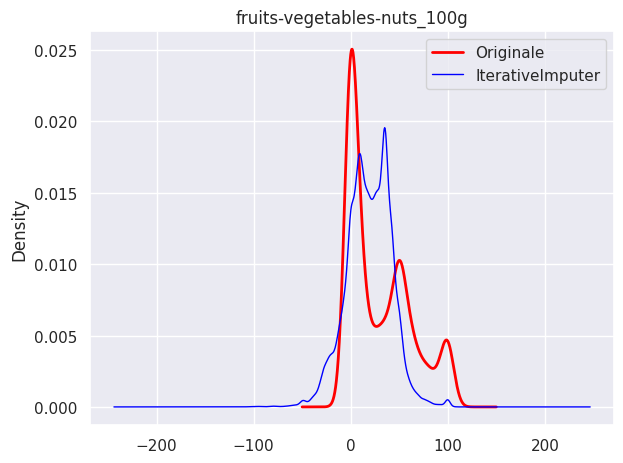

In [ ]:
iterative_nutri = impute_and_check(IterativeImputer(), nut_score, df_imputed, 'IterativeImputer')

In [ ]:
iterative_nutri.describe() - df_imputed[nut_score].describe()

energy_100g  saturated-fat_100g  sugars_100g    fiber_100g  \
count          0.0                 0.0          0.0  18301.000000   
mean           0.0                 0.0          0.0     -0.005098   
std            0.0                 0.0          0.0     -0.220071   
min            0.0                 0.0          0.0     -8.862626   
25%            0.0                 0.0          0.0      0.200000   
50%            0.0                 0.0          0.0      0.200000   
75%            0.0                 0.0          0.0     -0.300000   
max            0.0                 0.0          0.0      9.611644   

       proteins_100g  salt_100g  fruits-vegetables-nuts_100g  
count      77.000000  79.000000                 56252.000000  
mean        0.000055   0.000009                   -11.172275  
std        -0.005106  -0.002446                    -9.395077  
min         0.000000   0.000000                  -121.208754  
25%         0.085000   0.000000                     4.221100  
50%         0.000000   0.000000                     2.224304  
75%         0.000000  -0.000640                   -14.905293  
max         0.000000   0.000000                    24.063618

In [ ]:
df_imputed[["fiber_100g", "proteins_100g", "salt_100g"]] = knn_corr_score[["fiber_100g", "proteins_100g", "salt_100g"]]

# Nutrition score prediction with main columns except for fruits-vegetables-nuts

In [ ]:
nut_score.remove("fruits-vegetables-nuts_100g")

accuracy = predict_grade(nut_score, df_imputed)
results_summary = results_summary._append({'test_name': f'{len(nut_score)} main variables', 'shape': df_imputed[nut_score].shape, 'accuracy': accuracy}, ignore_index=True)
results_summary

(58958, 7)

test_name       shape  accuracy
0  3 main variables  (58958, 3)  0.693691
1  6 main variables  (58958, 6)  0.862280

# Add main variables

## Imputation

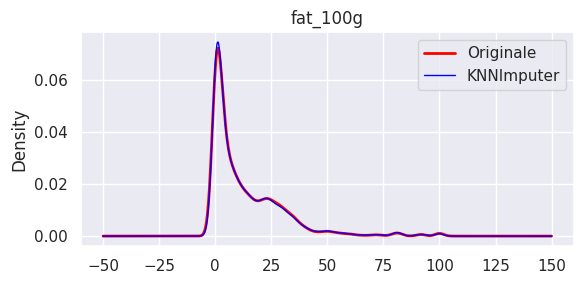

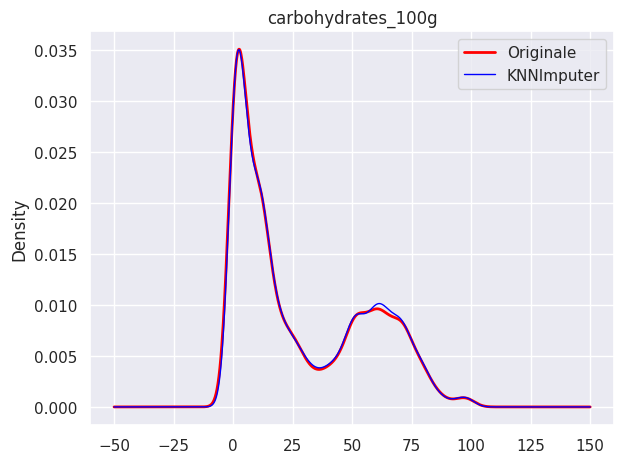

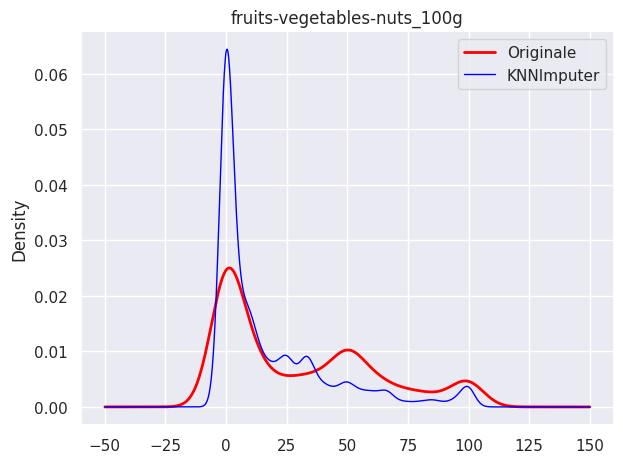

In [ ]:
knn_main_nutr = impute_and_check(KNNImputer(n_neighbors=3), main_col, df_imputed, 'KNNImputer', to_display=['fat_100g', 'carbohydrates_100g', "fruits-vegetables-nuts_100g"])

In [ ]:
knn_main_nutr[['fat_100g', 'carbohydrates_100g', "fruits-vegetables-nuts_100g"]].describe() - df_imputed[['fat_100g', 'carbohydrates_100g', "fruits-vegetables-nuts_100g"]].describe()

fat_100g  carbohydrates_100g  fruits-vegetables-nuts_100g
count  16618.000000        16672.000000                 56252.000000
mean       0.045624            0.525582                   -12.292259
std        0.123034            0.040029                    -7.213202
min        0.000000            0.000000                     0.000000
25%        0.100000            0.333333                     0.000000
50%        0.000000            0.800000                   -10.783333
75%        0.000000            1.000000                   -22.666667
max        0.000000            0.000000                     0.000000

In [ ]:
df_imputed["fat_100g"] = knn_main_nutr["fat_100g"]
df_imputed["carbohydrates_100g"] = knn_main_nutr["carbohydrates_100g"]

In [ ]:
main_col.remove('nutrition-score-fr_100g')
main_col.remove('fruits-vegetables-nuts_100g')

In [ ]:
df_imputed.head()

code                             product_name        brands  \
235743  3501430000129           Mogettes cuisinees a la tomate         01vac   
237726  3560070193943                          Nectar d'Orange             1   
248244  3609761400219       Sauce Tomate Olive Méditerranéenne     1.2.3.BIO   
248585  3660668001978         Jus d'orange à base de concentré  1 2 3 Fruits   
248587  3660668002005  Jus de pamplemousse à base de concentré  1 2 3 Fruits   

       serving_size nutrition_grade_fr   pnns_groups_1         pnns_groups_2  \
235743          NaN                  a         unknown               unknown   
237726        20 cl                  d       Beverages         Fruit nectars   
248244          NaN                  c  Fat and sauces  Dressings and sauces   
248585         25cl                  c       Beverages          Fruit juices   
248587          NaN                  b       Beverages          Fruit juices   

        energy_100g  energy-from-fat_100g  fat_100g  saturated-fat_100g  \
235743        272.0                   NaN      0.60                0.10   
237726         85.0                   NaN      0.03                0.01   
248244        292.0                   NaN      4.40                0.70   
248585        205.0                   NaN      0.00                0.00   
248587        138.0                   NaN      0.10                0.00   

        lauric-acid_100g  arachidic-acid_100g  monounsaturated-fat_100g  \
235743               NaN                  NaN                       NaN   
237726               NaN                  NaN                       NaN   
248244               NaN                  NaN                       NaN   
248585               0.0                  0.0                       0.0   
248587               NaN                  NaN                       NaN   

        polyunsaturated-fat_100g  omega-3-fat_100g  alpha-linolenic-acid_100g  \
235743                       NaN               NaN                        NaN   
237726                       NaN               NaN                        NaN   
248244                       NaN               NaN                        NaN   
248585                       0.0               0.0                        0.0   
248587                       NaN               NaN                        NaN   

        eicosapentaenoic-acid_100g  docosahexaenoic-acid_100g  \
235743                         NaN                        NaN   
237726                         NaN                        NaN   
248244                         NaN                        NaN   
248585                         0.0                        0.0   
248587                         NaN                        NaN   

        omega-6-fat_100g  linoleic-acid_100g  arachidonic-acid_100g  \
235743               NaN                 NaN                    NaN   
237726               NaN                 NaN                    NaN   
248244               NaN                 NaN                    NaN   
248585               0.0                 0.0                    0.0   
248587               NaN                 NaN                    NaN   

        gamma-linolenic-acid_100g  omega-9-fat_100g  oleic-acid_100g  \
235743                        NaN               NaN              NaN   
237726                        NaN               NaN              NaN   
248244                        NaN               NaN              NaN   
248585                        0.0               0.0              0.0   
248587                        NaN               NaN              NaN   

        trans-fat_100g  cholesterol_100g  carbohydrates_100g  sugars_100g  \
235743             NaN               NaN                 8.6          0.4   
237726             NaN               NaN                 4.7          4.7   
248244             NaN               NaN                 5.7          3.4   
248585             0.0               0.0                11.0         11.0   
248587             NaN        

## Prediction

In [ ]:
accuracy = predict_grade(main_col, df_imputed)
results_summary = results_summary._append({'test_name': f'{len(main_col)} main variables', 'shape': df_imputed[main_col].shape, 'accuracy': accuracy}, ignore_index=True)
results_summary

(58958, 9)

test_name       shape  accuracy
0  3 main variables  (58958, 3)  0.693691
1  6 main variables  (58958, 6)  0.862280
2  8 main variables  (58958, 8)  0.866435

# Fruits-vegetables-nuts

In [ ]:
df_imputed['fruits-vegetables-nuts_100g'].describe()

count    2706.000000
mean       30.111223
std        32.230453
min         0.000000
25%         0.000000
50%        17.150000
75%        50.000000
max       100.000000
Name: fruits-vegetables-nuts_100g, dtype: float64

## Not fruits, veggies nor nuts products

In [ ]:
df_imputed['pnns_groups_2'].unique()

array(['unknown', 'Fruit nectars', 'Dressings and sauces', 'Fruit juices',
       nan, 'Non-sugared beverages', 'Biscuits and cakes', 'Legumes',
       'One-dish meals', 'Appetizers', 'Sweets', 'Chocolate products',
       'Sweetened beverages', 'Milk and yogurt', 'pastries',
       'Dried fruits', 'Fish and seafood', 'Cereals', 'Processed meat',
       'Meat', 'Salty and fatty products', 'Breakfast cereals',
       'Sandwich', 'Cheese', 'Ice cream', 'fruits', 'Alcoholic beverages',
       'Artificially sweetened beverages', 'Fats', 'Potatoes',
       'Vegetables', 'Bread', 'Nuts', 'Fruits', 'Pizza pies and quiche',
       'vegetables', 'Dairy desserts', 'Soups', 'Eggs', 'Tripe dishes',
       'cereals'], dtype=object)

In [ ]:
# fruits-vegetables-nuts_100g : % of fruits, vegetables and nuts (excluding potatoes, yams, manioc)
not_fvn_products = ['unknown', 'Non-sugared beverages', 'Eggs', 'Sweetened beverages',
                    'Alcoholic beverages', 'Fats', 'Potatoes',
                    'Artificially sweetened beverages', 'Ice cream', 'cereals']

In [ ]:
df_imputed.loc[(df_imputed['fruits-vegetables-nuts_100g'].isna()) & (df_imputed['pnns_groups_2'].isin(not_fvn_products)), 'fruits-vegetables-nuts_100g'] = 0

In [ ]:
df_imputed['fruits-vegetables-nuts_100g'].isna().mean()*100

78.48807625767495

## PNNS 2 mean

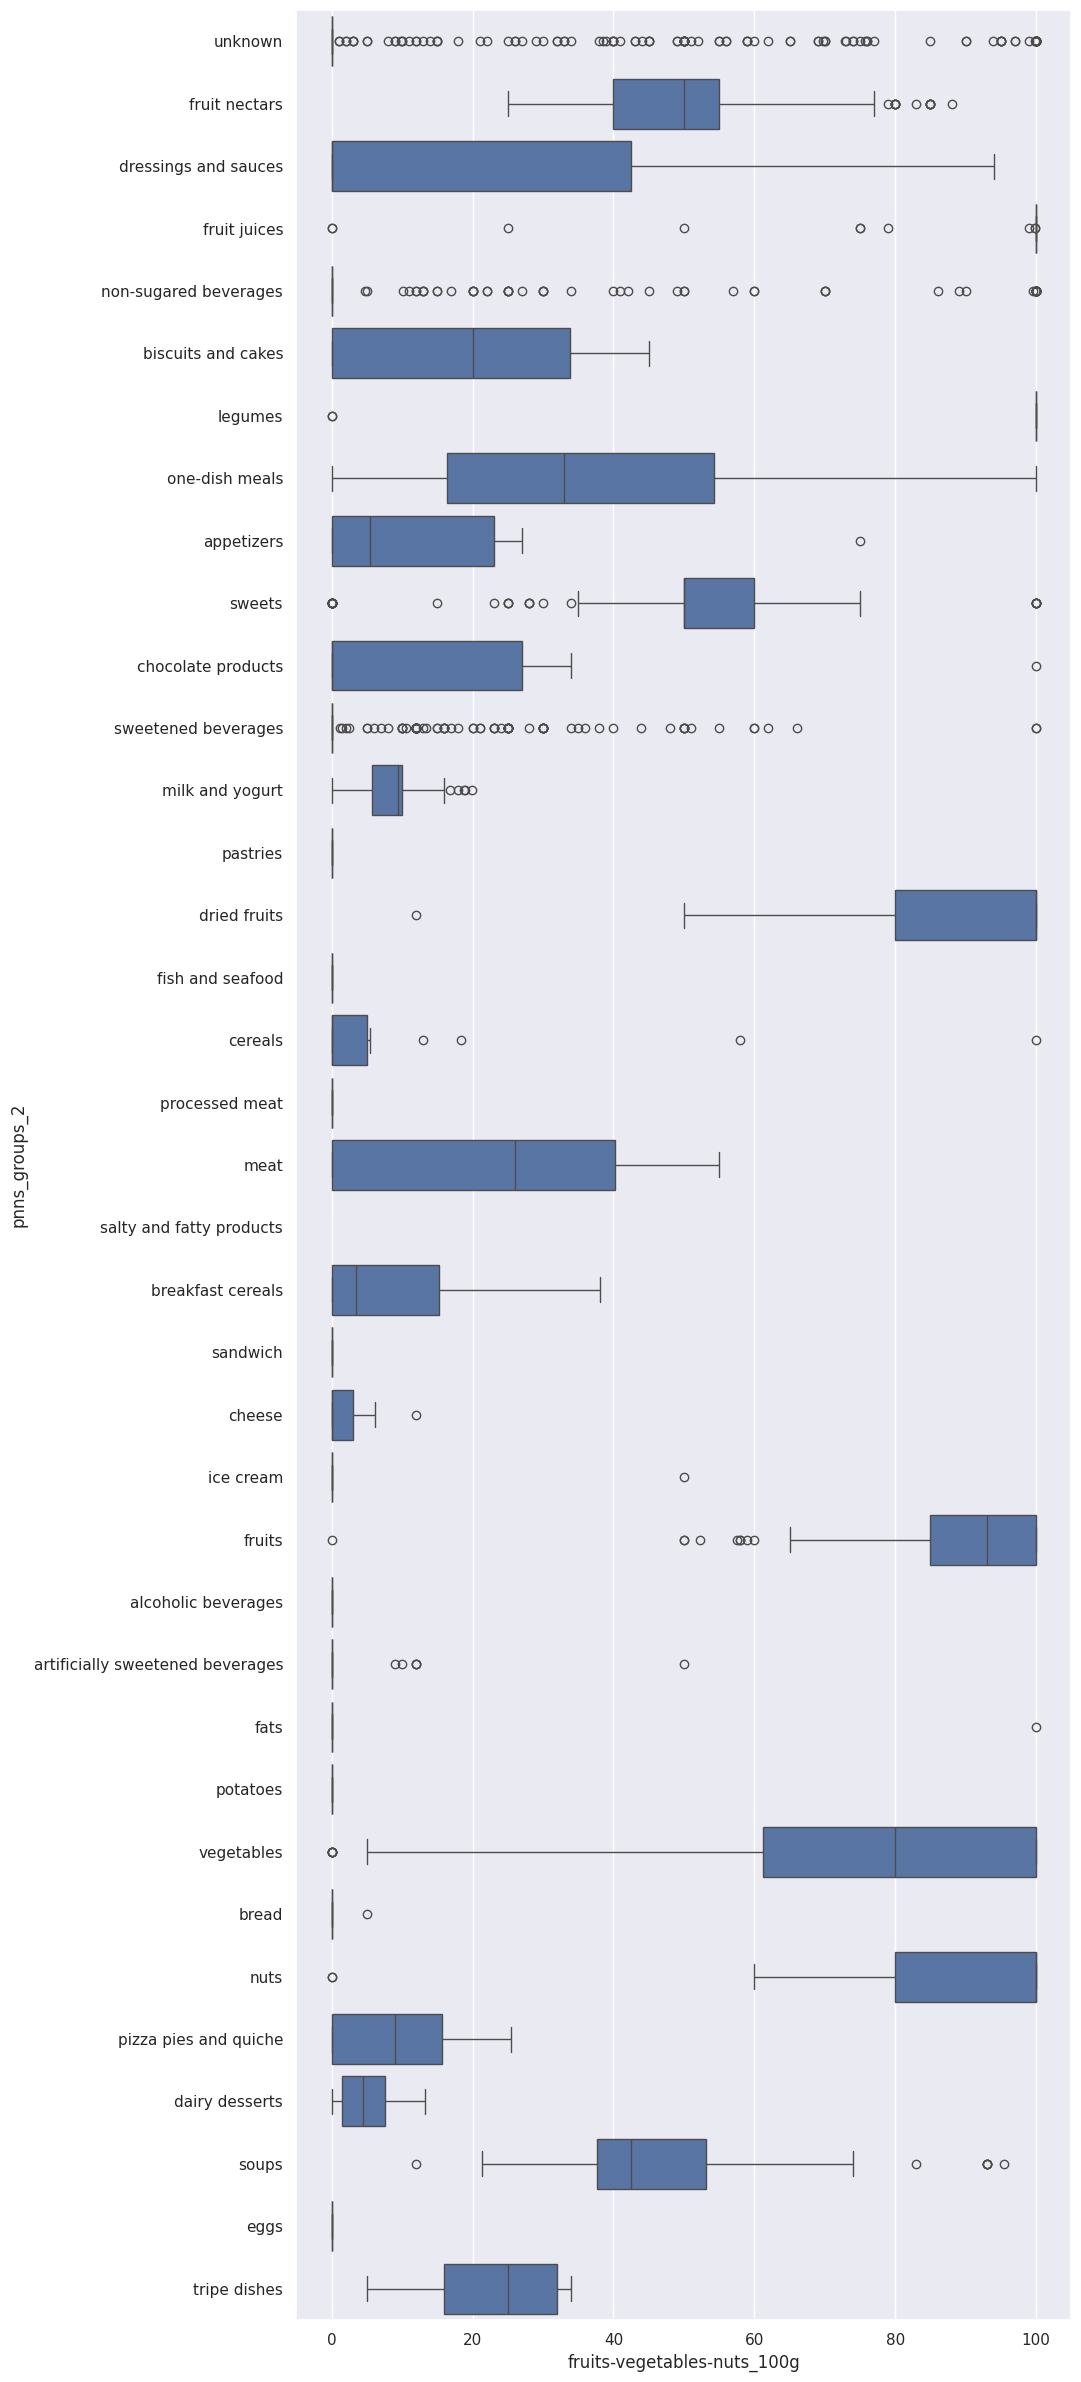

In [ ]:
df_imputed['pnns_groups_2'] = df_imputed['pnns_groups_2'].str.lower()
groupby_pnns = df_imputed.copy()


fig, ax = plt.subplots(figsize=(10,30))
sns.boxplot(ax=ax, y='pnns_groups_2', x='fruits-vegetables-nuts_100g', data=groupby_pnns)

plt.show()

In [ ]:
df_fvn = df_imputed.copy()
replace_with_pnns_stats(df_fvn, 'pnns_groups_2','fruits-vegetables-nuts_100g', "mean")

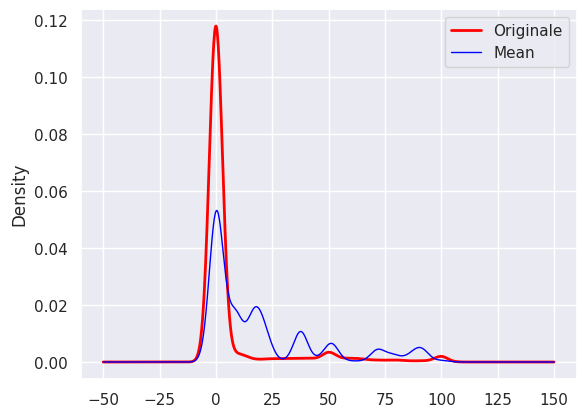

In [ ]:
df_imputed['fruits-vegetables-nuts_100g'].plot(kind="kde", c="red", label='Original', linewidth=2)
df_fvn['fruits-vegetables-nuts_100g'].plot(kind="kde", c="blue", label='mean', linewidth=1)

labels = ["Originale", "Mean"]
plt.legend(labels)
plt.show()

In [ ]:
df_fvn['fruits-vegetables-nuts_100g'].describe() - df_imputed['fruits-vegetables-nuts_100g'].describe()

count    32547.000000
mean        11.993435
std         10.219267
min          0.000000
25%          0.000000
50%          0.000000
75%         33.000000
max          0.000000
Name: fruits-vegetables-nuts_100g, dtype: float64

In [ ]:
df_imputed['fruits-vegetables-nuts_100g'].isna().mean()*100

77.18206180670985

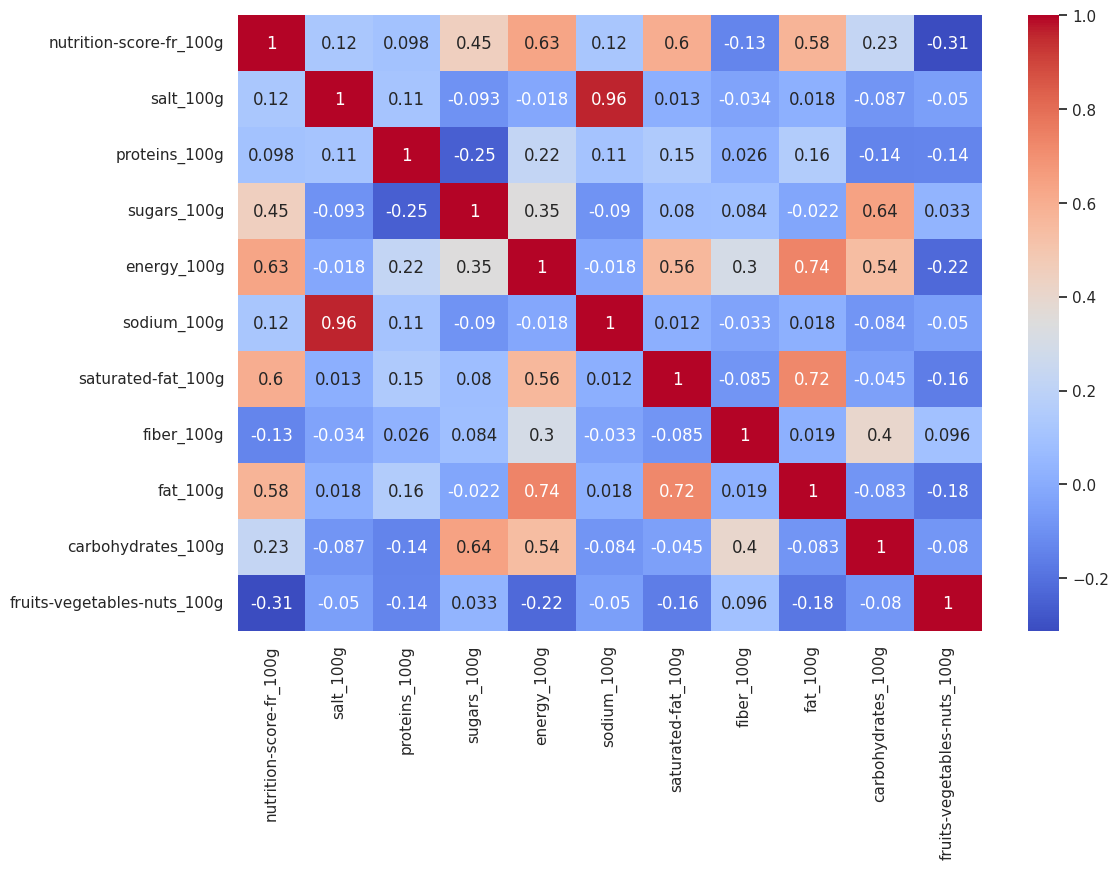

In [ ]:
display_corr(df_imputed, columns_to_keep)

In [ ]:
main_col, columns_to_keep

(['proteins_100g',
  'sugars_100g',
  'energy_100g',
  'saturated-fat_100g',
  'fiber_100g',
  'fat_100g',
  'carbohydrates_100g',
  'omega-3-fat_100g'],
 ['nutrition-score-fr_100g',
  'proteins_100g',
  'sugars_100g',
  'energy_100g',
  'saturated-fat_100g',
  'fiber_100g',
  'fat_100g',
  'carbohydrates_100g',
  'fruits-vegetables-nuts_100g',
  'sodium_100g'])

## KNN imputer

In [ ]:
main_col

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'nutrition-score-fr_100g']

In [ ]:
df_fvn_test, best_n_neighbors = test_subset(columns_to_keep, df_imputed, scaler=StandardScaler())

 test df shape : (13402, 11)
Best n_neighbors: 3 with MSE of 1729.0747


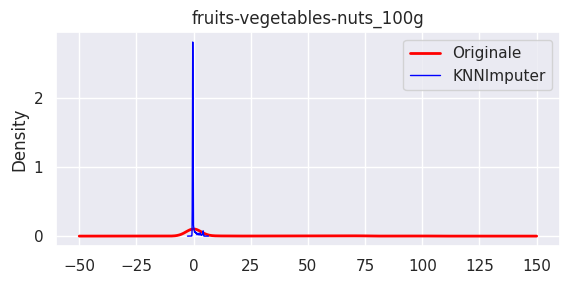

In [ ]:
df_fvn_knn = impute_and_check(KNNImputer(n_neighbors=3), columns_to_keep, df_imputed, 'KNNImputer', to_display=['fruits-vegetables-nuts_100g'], scaler=StandardScaler())

In [ ]:
df_fvn_knn['fruits-vegetables-nuts_100g'].isnull().sum()

0

In [ ]:
df_fvn_knn['fruits-vegetables-nuts_100g'].describe() - df_imputed['fruits-vegetables-nuts_100g'].describe()

count    44397.000000
mean        -8.031550
std        -20.796200
min         -0.369555
25%         -0.369555
50%         -0.369555
75%         -0.369555
max        -95.767537
Name: fruits-vegetables-nuts_100g, dtype: float64

## Iterative imputer

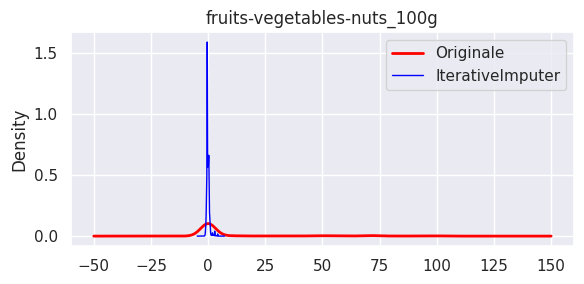

In [ ]:
df_fnv_iterative = impute_and_check(IterativeImputer(), main_col, df_imputed, 'IterativeImputer', to_display=['fruits-vegetables-nuts_100g'], scaler=StandardScaler())

# ACP

To validate our choice of variables, let's proceed to an ACP

## Finding the appropriate numeber of components

In [ ]:
main_col = main_col + ["nutrition-score-fr_100g"]

In [ ]:
# selected_columns.remove('sodium_100g')

In [ ]:
df_imputed[main_col].isnull().sum()

energy_100g                0
fat_100g                   0
saturated-fat_100g         0
carbohydrates_100g         0
sugars_100g                0
fiber_100g                 0
proteins_100g              0
salt_100g                  0
nutrition-score-fr_100g    0
dtype: int64

In [ ]:
df_acp = df_imputed.copy()
# df_acp.dropna(subset=["fruits-vegetables-nuts_100g"],inplace=True)
df_acp.shape

(58958, 82)

In [ ]:
columns = main_col
columns

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'nutrition-score-fr_100g']

In [ ]:
# Normalize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_acp[columns])


## Elbow graph

In [ ]:
pca = PCA()
pca.fit(df_scaled)

PCA()

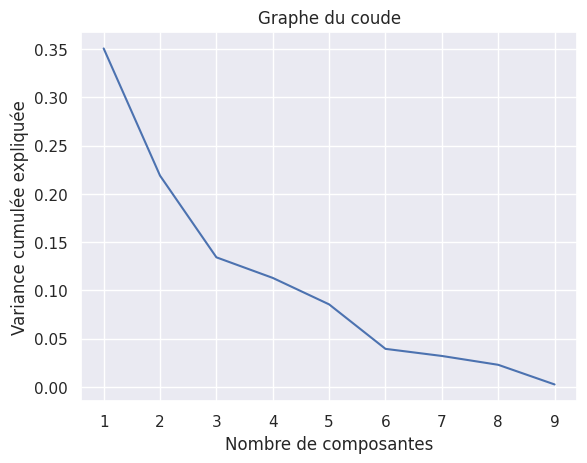

Number of components to keep : 4


In [ ]:
cumulated_var = pca.explained_variance_ratio_

plt.plot(range(1, len(cumulated_var) + 1), cumulated_var)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée expliquée')
plt.title('Graphe du coude')
plt.show()

scree_values = pca.explained_variance_

seuil = np.mean(scree_values)
n_components = np.sum(scree_values >= seuil)

print(f"Number of components to keep : {n_components}")


# ACP avec le nombre de composantes sélectionné
pca = PCA(n_components=n_components)
pca.fit(df_scaled)

# Récupération des composantes principales
main_components = pca.transform(df_scaled)

In [ ]:
df_acp.shape

(58958, 82)

In [ ]:
# Check that we don't have any missing values left
df_acp.isna().mean()

code                                0.000000
product_name                        0.002544
brands                              0.003562
serving_size                        0.603124
nutrition_grade_fr                  0.000000
pnns_groups_1                       0.234150
pnns_groups_2                       0.232606
energy_100g                         0.000000
energy-from-fat_100g                0.999491
fat_100g                            0.000000
saturated-fat_100g                  0.000000
lauric-acid_100g                    0.944503
arachidic-acid_100g                 0.944503
monounsaturated-fat_100g            0.926660
polyunsaturated-fat_100g            0.926354
omega-3-fat_100g                    0.935157
alpha-linolenic-acid_100g           0.941840
eicosapentaenoic-acid_100g          0.944231
docosahexaenoic-acid_100g           0.943892
omega-6-fat_100g                    0.942671
linoleic-acid_100g                  0.942332
arachidonic-acid_100g               0.944384
gamma-linolenic-acid_100g           0.944503
omega-9-fat_100g                    0.944215
oleic-acid_100g                     0.944452
trans-fat_100g                      0.939414
cholesterol_100g                    0.939177
carbohydrates_100g                  0.000000
sugars_100g                         0.000000
sucrose_100g                        0.970640
glucose_100g                        0.970776
fructose_100g                       0.970555
lactose_100g                        0.968571
maltose_100g                        0.970776
maltodextrins_100g                  0.970657
starch_100g                         0.968181
polyols_100g                        0.965925
fiber_100g                          0.000000
proteins_100g                       0.000000
casein_100g                         0.999593
serum-proteins_100g                 0.999763
nucleotides_100g                    0.999881
salt_100g                           0.000000
sodium_100g                         0.001306
alcohol_100g                        0.989586
vitamin-a_100g                      0.991011
beta-carotene_100g                  0.999881
vitamin-d_100g                      0.991299
vitamin-e_100g                      0.988178
vitamin-k_100g                      0.998931
vitamin-c_100g                      0.980698
vitamin-b1_100g                     0.987245
vitamin-b2_100g                     0.990332
vitamin-pp_100g                     0.989484
vitamin-b6_100g                     0.988890
vitamin-b9_100g                     0.989264
vitamin-b12_100g                    0.991757
vitamin-b8_100g                     0.997201
vitamin-b5_100g                     0.993521
silica_100g                         0.999898
bicarbonate_100g                    0.999796
potassium_100g                      0.996031
chloride_100g                       0.999084
calcium_100g                        0.967621
phosphorus_100g                     0.991859
iron_100g                           0.982479
magnesium_100g                      0.989145
zinc_100g                           0.996540
copper_100g                         0.998236
manganese_100g                      0.998389
fluoride_100g                       0.999288
selenium_100g                       0.998643
chromium_100g                       0.999898
molybdenum_100g                     0.999966
iodine_100g                         0.998151
caffeine_100g                       0.999525
taurine_100g                        0.999593
fruits-vegetables-nuts_100g         0.784881
collagen-meat-protein-ratio_100g    0.998287
cocoa_100g                          0.989772
nutrition-score-fr_100g             0.000000
color                               0.000000
dtype: float64

## Data split

In [ ]:
X = df_acp[columns].values
# show first rows
X[:5]

array([[ 2.72e+02,  6.00e-01,  1.00e-01,  8.60e+00,  4.00e-01,  3.30e+00,
         4.60e+00,  8.50e-01, -3.00e+00],
       [ 8.50e+01,  3.00e-02,  1.00e-02,  4.70e+00,  4.70e+00,  1.00e-01,
         2.00e-01,  5.08e-03,  7.00e+00],
       [ 2.92e+02,  4.40e+00,  7.00e-01,  5.70e+00,  3.40e+00,  1.40e+00,
         1.20e+00,  1.40e+00,  5.00e+00],
       [ 2.05e+02,  0.00e+00,  0.00e+00,  1.10e+01,  1.10e+01,  0.00e+00,
         5.00e-01,  0.00e+00,  5.00e+00],
       [ 1.38e+02,  1.00e-01,  0.00e+00,  7.60e+00,  7.60e+00,  1.00e-01,
         5.00e-01,  1.00e-02,  1.00e+00]])

In [ ]:
type(X), X.shape

(numpy.ndarray, (58958, 9))

In [ ]:
names = df_acp.index
names[:5]

Index([235743, 237726, 248244, 248585, 248587], dtype='int64')

In [ ]:
features = columns
features

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'nutrition-score-fr_100g']

## Standardize

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
idx = ['mean', 'std']
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8
mean -0.0  0.0 -0.0 -0.0 -0.0  0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## PCA

## Ebouli graph

In [ ]:
n_components = 6

pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=6)

Let's look at variance for each component

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
scree_cum

array([35., 57., 70., 82., 90., 94.])

In [ ]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

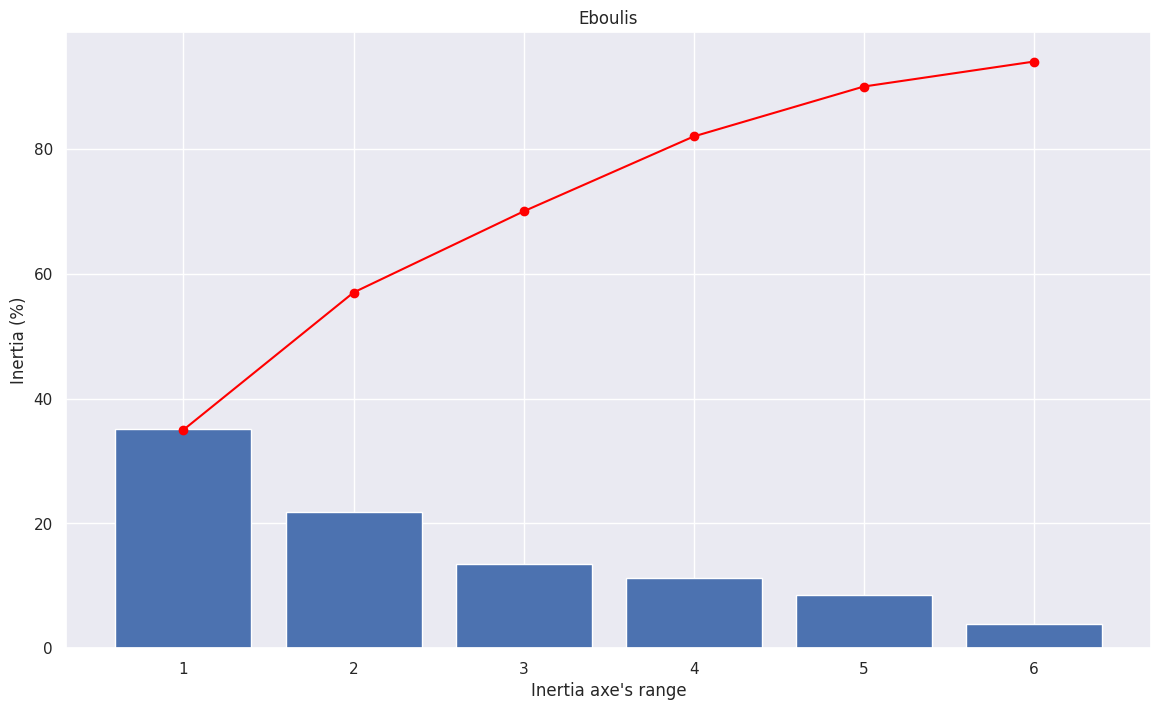

In [ ]:
fig,ax=plt.subplots(figsize=(14,8))
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Inertia axe's range")
plt.ylabel("Inertia (%)")
plt.title("Eboulis")
plt.show(block=False)

The first component explains the variance (high inertia).

The inertia is getting lower for each component coming next.

To explain the variance, we'll need 4 components (explaining over 80% of the variance).

## Components

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5         6  \
0  0.520016  0.442673  0.421851  0.238448  0.254824  0.084260  0.091453   
1 -0.068046  0.315348  0.298407 -0.580065 -0.486279 -0.328517  0.307800   
2  0.220998  0.050028 -0.116788  0.112562 -0.340632  0.672030  0.517055   
3 -0.049922 -0.192881 -0.144889  0.110805  0.150568 -0.084413  0.153546   
4 -0.001376  0.275683  0.146030 -0.130956 -0.221564  0.392846 -0.747310   
5 -0.417608 -0.271274  0.436485 -0.372223  0.368582  0.473906  0.132330   

          7         8  
0  0.011793  0.467195  
1  0.164996  0.063618  
2  0.081573 -0.284065  
3  0.914650  0.192552  
4  0.323997 -0.136596  
5 -0.048394  0.206523

In [ ]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
F1         0.52      0.44                0.42                0.24   
F2        -0.07      0.32                0.30               -0.58   
F3         0.22      0.05               -0.12                0.11   
F4        -0.05     -0.19               -0.14                0.11   
F5        -0.00      0.28                0.15               -0.13   
F6        -0.42     -0.27                0.44               -0.37   

    sugars_100g  fiber_100g  proteins_100g  salt_100g  nutrition-score-fr_100g  
F1         0.25        0.08           0.09       0.01                     0.47  
F2        -0.49       -0.33           0.31       0.16                     0.06  
F3        -0.34        0.67           0.52       0.08                    -0.28  
F4         0.15       -0.08           0.15       0.91                     0.19  
F5        -0.22        0.39          -0.75       0.32                    -0.14  
F6         0.37        0.47           0.13      -0.05                     0.21

Let's transpose the dataframe for the visualization

In [ ]:
pcs.T

F1        F2        F3        F4        F5  \
energy_100g              0.520016 -0.068046  0.220998 -0.049922 -0.001376   
fat_100g                 0.442673  0.315348  0.050028 -0.192881  0.275683   
saturated-fat_100g       0.421851  0.298407 -0.116788 -0.144889  0.146030   
carbohydrates_100g       0.238448 -0.580065  0.112562  0.110805 -0.130956   
sugars_100g              0.254824 -0.486279 -0.340632  0.150568 -0.221564   
fiber_100g               0.084260 -0.328517  0.672030 -0.084413  0.392846   
proteins_100g            0.091453  0.307800  0.517055  0.153546 -0.747310   
salt_100g                0.011793  0.164996  0.081573  0.914650  0.323997   
nutrition-score-fr_100g  0.467195  0.063618 -0.284065  0.192552 -0.136596   

                               F6  
energy_100g             -0.417608  
fat_100g                -0.271274  
saturated-fat_100g       0.436485  
carbohydrates_100g      -0.372223  
sugars_100g              0.368582  
fiber_100g               0.473906  
proteins_100g            0.132330  
salt_100g               -0.048394  
nutrition-score-fr_100g  0.206523

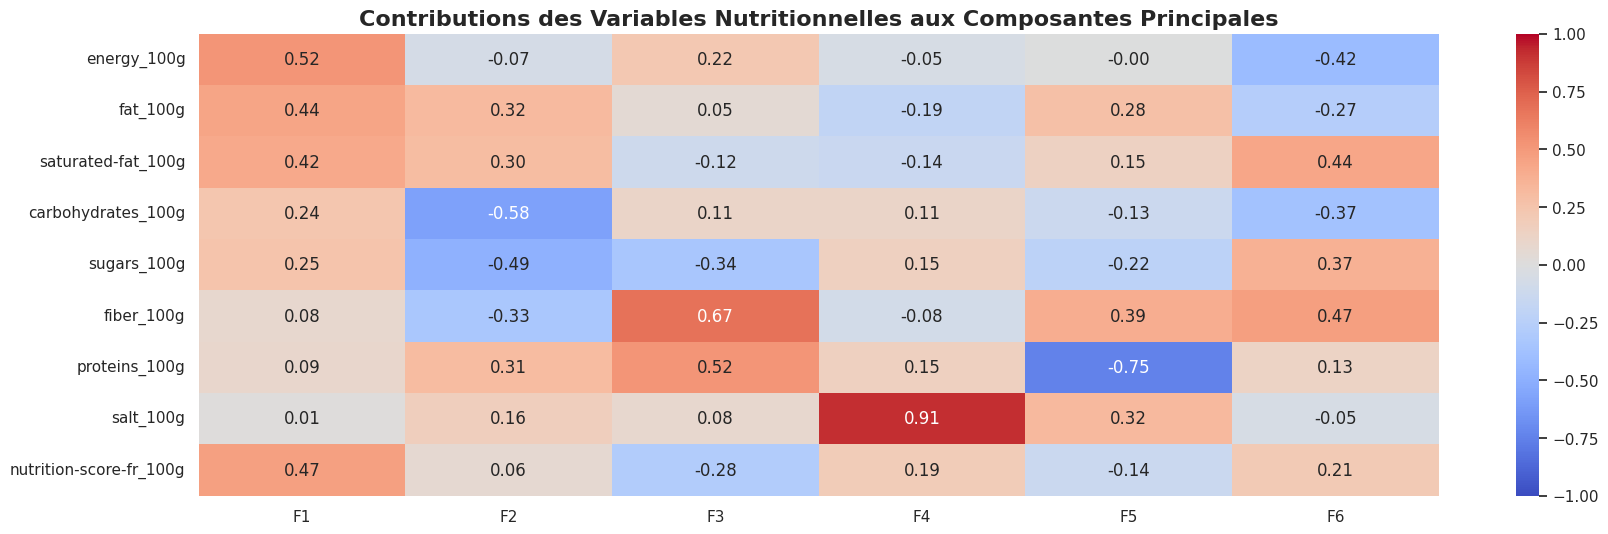

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
# Ajouter le titre
ax.set_title("Contributions des Variables Nutritionnelles aux Composantes Principales", fontsize=16, weight='bold')

plt.show()

F1 mostly influenced by energy

## Correlation graph

In [ ]:
x_y = (0,1)
x_y

(0, 1)

In [ ]:
pca.components_.shape[1]

9

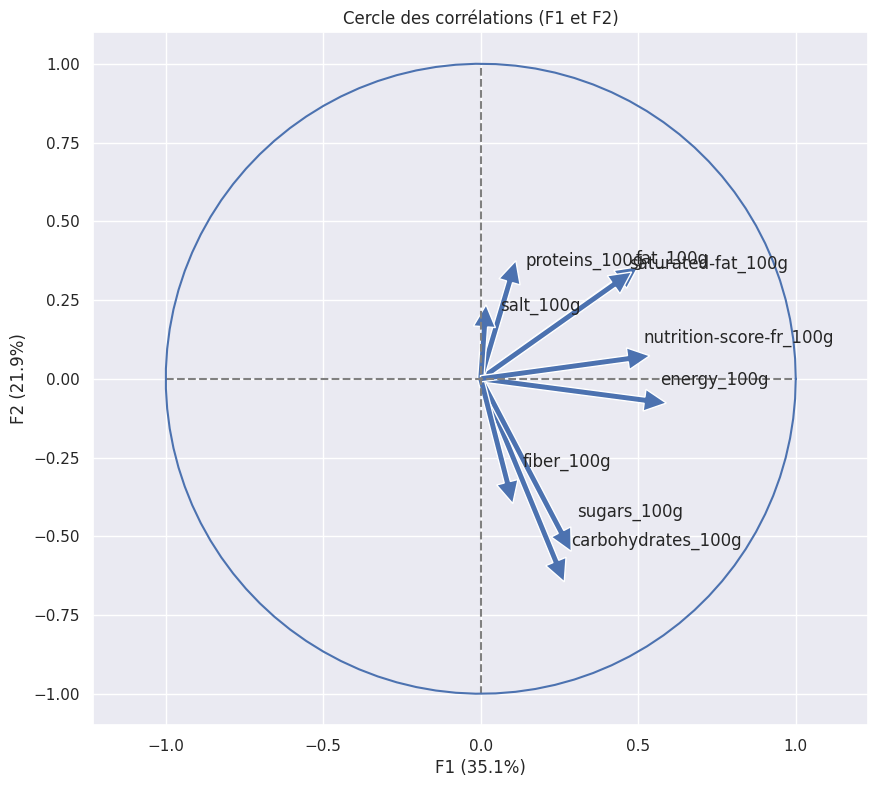

In [ ]:
correlation_graph(pca, x_y, pcs.columns)

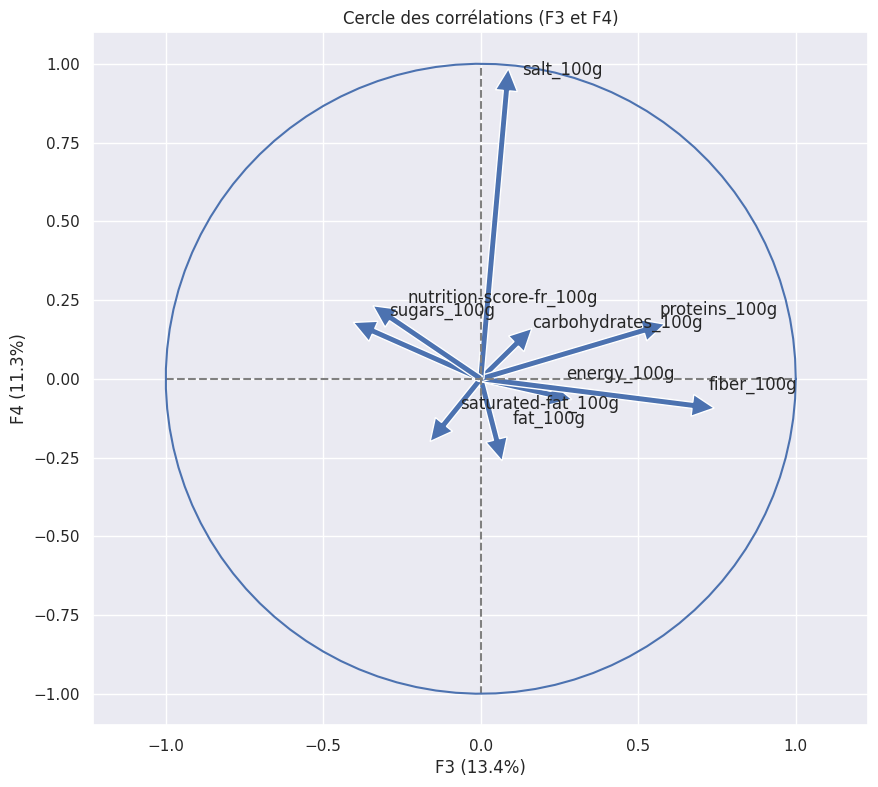

In [ ]:
correlation_graph(pca, (2, 3), pcs.columns)